
# ====================================================

# 🧠 ASD Detection: Hybrid MRI + Clinical Model

# ====================================================


## TensorFlow Hybrid (End-to-End)


###

This notebook demonstrates how to build a **hybrid deep learning model** that combines:

* **MRI image features** (via ResNet50 CNN backbone)
* **Clinical metadata** (scaled numeric values such as age, FIQ, Sex etc.)

using a **tf.data pipeline** for efficient memory handling.

The workflow includes:

1. **Data preprocessing** (clinical CSV + MRI images)
2. **tf.data pipeline with augmentation**
3. **Hybrid model (ResNet + Clinical branch)**
4. **Training with callbacks & class weights**
5. **Evaluation (confusion matrix, ROC, PR curves)**
6. **Inference function (`predict_single`)**

---

=========================================================================================================================

---

## 1) Imports & Config

###  Explanation

Here we import all required libraries:

* **Core Python**: os, glob, pickle
* **Data science**: pandas, numpy, matplotlib, seaborn
* **TensorFlow / Keras**: ResNet50 backbone, layers, optimizers, callbacks
* **Sklearn**: preprocessing (StandardScaler), metrics (confusion matrix, AUC, PR curves)

We also configure some warning suppression for cleaner output.



In [2]:

import cv2
import os
import math
import glob
import pickle
import warnings

import os, glob, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score

from tensorflow.keras.utils import load_img, img_to_array
warnings.filterwarnings('ignore')


2025-09-27 13:44:12.093409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758980652.286697      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758980652.341586      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2) Settings

### 📝 Explanation

We define **global constants**:

* Dataset paths (`DATASET_PATH`, `ASD_DIR`, `NON_ASD_DIR`, `META_PATH`)
* Model parameters (image size, batch size, epochs, random seed)
* Paths for saving trained model (`.keras`) and clinical scaler (`.pkl`)




In [3]:

# ---------- USER CONFIG ----------
DATASET_PATH = "/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET"
META_PATH = os.path.join(DATASET_PATH, "imputed_Upd_cleaned.csv")
ASD_DIR = os.path.join(DATASET_PATH, "ASD")
NON_ASD_DIR = os.path.join(DATASET_PATH, "NON-ASD")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
MODEL_SAVE_PATH = "hybrid_mri_clinical_tfmodel.keras"
SCALER_SAVE_PATH = 'clinical_scaler.pkl'
RANDOM_STATE = 42
# ----------------------------------

---

## 3) Clinical Data Preprocessing

### 📝 Explanation

* Load clinical CSV file
* Set `SUB_ID` as index (subject ID must match image filenames like `50254.jpg`)
* Drop `FILE_PATH` column if redundant
* Merge clinical and imaging metadata

We then scale clinical numerical features using **StandardScaler** and save the scaler to disk for inference.

    Normalizing clinical features using `StandardScaler`:

$$
x' = \frac{x - \mu}{\sigma}
$$

where:

* $x$ = raw clinical feature value
* $\mu$ = mean of feature (computed on training set)
* $\sigma$ = standard deviation of feature

This ensures all clinical inputs (e.g., **AGE_AT_SCAN, SEX, BMI, FIQ etc**) are on the same scale, preventing features with larger ranges from dominating learning.




    Raw Clinical Data  --->  StandardScaler  --->  Normalized Clinical Vector




... (some code for joining, merging, scaler saving, etc.)


In [4]:

# 1) Load clinical metadata
clinical_df = pd.read_csv(META_PATH)
clinical_df.set_index('SUB_ID', inplace=True)
# drop FILE_PATH if exists in metadata
clinical_df = clinical_df.drop(columns=['FILE_PATH'], errors='ignore')
clinical_df

SEX  DX_GROUP  ADI_R_SOCIAL_TOTAL_A  ADI_R_VERBAL_TOTAL_BV  \
SUB_ID                                                               
50002     1       1.0             16.000000               9.000000   
50003     1       1.0             27.000000              22.000000   
50004     1       1.0             19.000000              12.000000   
50005     0       1.0             23.000000              19.000000   
50006     1       1.0             13.000000              10.000000   
...     ...       ...                   ...                    ...   
29134     1       0.0             -1.537239               6.296503   
29135     1       0.0             -1.537239               6.296503   
29136     1       0.0             -1.537239               6.296503   
29137     1       0.0             -1.537239               6.296503   
29225     0       0.0             -1.537239               6.296503   

        ADI_RRB_TOTAL_C  ADI_R_ONSET_TOTAL_D  ADI_R_RSRCH_RELIABLE  \
SUB_ID                                                               
50002          5.000000             4.000000              1.000000   
50003          5.000000             3.000000              1.000000   
50004          5.000000             3.000000              1.000000   
50005          3.000000             4.000000              1.000000   
50006          4.000000             3.000000              1.000000   
...                 ...                  ...                   ...   
29134         -4.176392            -0.146172             -0.230726   
29135         -4.176392            -0.146172             -0.230726   
29136         -4.176392            -0.146172             -0.230726   
29137         -4.176392            -0.146172             -0.230726   
29225         -4.176392            -0.146172             -0.230726   

        ADOS_MODULE  ADOS_RSRCH_RELIABLE  ADOS_TOTAL  ...  \
SUB_ID                                                ...   
50002       4.00000             1.000000   12.000000  ...   
50003       4.00000             1.000000   13.000000  ...   
50004       4.00000             1.000000   18.000000  ...   
50005       4.00000             1.000000   12.000000  ...   
50006       4.00000             1.000000   12.000000  ...   
...             ...                  ...         ...  ...   
29134       3.68787             0.965558   12.840066  ...   
29135       3.68787             0.965558   12.840066  ...   
29136       3.68787             0.965558   12.840066  ...   
29137       3.68787             0.965558   12.840066  ...   
29225       3.68787             0.965558   12.840066  ...   

        ADOS_GOTHAM_SOCAFFECT  ADOS_GOTHAM_RRB  ADOS_GOTHAM_TOTAL  \
SUB_ID                                                              
50002               24.637727        -4.817178          17.577424   
50003                8.444499        -6.039135           3.859973   
50004               -3.756426       -10.352092          -6.898391   
50005               12.815319         6.625861          19.082291   
50006               -4.682744        -3.138777         -11.334921   
...                       ...              ...                ...   
29134                8.308471        11.697888          19.440971   
29135                8.308471        11.697888          19.440971   
29136                8.308471        11.697888          19.440971   
29137                8.308471        11.697888          19.440971   
29225                8.308471        11.697888          19.440971   

        ADOS_GOTHAM_SEVERITY   anat_cnr  anat_efc  anat_fber  anat_fwhm  \
SUB_ID                                                                    
50002              23.340303  10.201539  1.194664  16.223458   3.878000   
50003               8.894091   7.165701  1.126752  10.460008   4.282238   
50004              13.105518   7.698144  1.226218   9.725750   3.881684   
50005              12.092832   9.071807  1.256278  11.198226   3.628667   
50006               7.848128   8.026798  1.4

## **Exploratory Data Analysis for Clinical Meta (Phenotypic Data)**

In [5]:
df = clinical_df

In [6]:
# find missing values
clinical_df.isnull().sum()

SEX                      0
DX_GROUP                 0
ADI_R_SOCIAL_TOTAL_A     0
ADI_R_VERBAL_TOTAL_BV    0
ADI_RRB_TOTAL_C          0
ADI_R_ONSET_TOTAL_D      0
ADI_R_RSRCH_RELIABLE     0
ADOS_MODULE              0
ADOS_RSRCH_RELIABLE      0
ADOS_TOTAL               0
ADOS_COMM                0
ADOS_SOCIAL              0
ADOS_STEREO_BEHAV        0
AGE_AT_SCAN              0
ADOS_GOTHAM_SOCAFFECT    0
ADOS_GOTHAM_RRB          0
ADOS_GOTHAM_TOTAL        0
ADOS_GOTHAM_SEVERITY     0
anat_cnr                 0
anat_efc                 0
anat_fber                0
anat_fwhm                0
anat_qi1                 0
anat_snr                 0
dtype: int64

In [7]:
# Target Col(DX_GROUP) Distribution

print("Shape:", df.shape)
# df.head()
print(df['DX_GROUP'].value_counts())   # 1 = ASD, 0 = Non-ASD (usually)


Shape: (1602, 24)
DX_GROUP
1.0    801
0.0    801
Name: count, dtype: int64


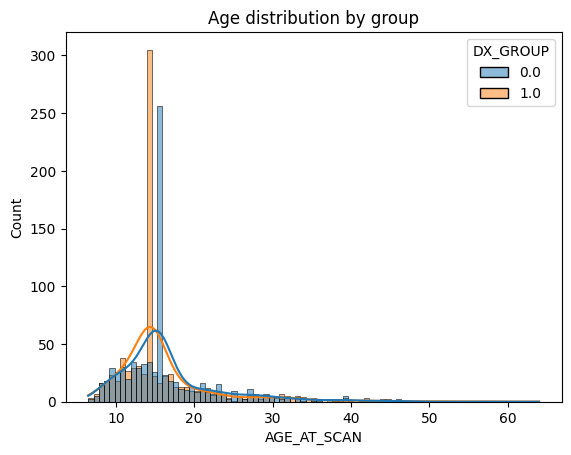

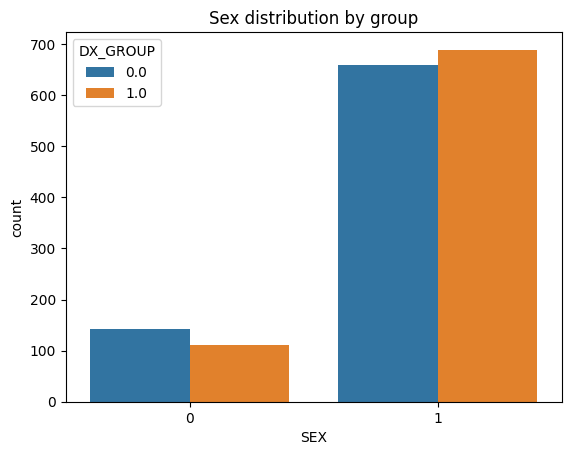

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age distribution
sns.histplot(df, x="AGE_AT_SCAN", hue="DX_GROUP", kde=True)
plt.title("Age distribution by group")
plt.show()

# Sex distribution
sns.countplot(x="SEX", hue="DX_GROUP", data=df)
plt.title("Sex distribution by group")
plt.show()


Correlation with DX_GROUP:
DX_GROUP                 1.000000
ADI_R_RSRCH_RELIABLE     0.173969
ADOS_SOCIAL              0.143285
ADOS_TOTAL               0.139372
anat_cnr                 0.102467
ADOS_RSRCH_RELIABLE      0.101877
ADI_R_ONSET_TOTAL_D      0.101500
anat_qi1                 0.088189
ADI_RRB_TOTAL_C          0.079621
ADI_R_VERBAL_TOTAL_BV    0.078631
anat_fber                0.078200
SEX                      0.051270
ADOS_COMM                0.035386
ADOS_GOTHAM_SOCAFFECT    0.023333
anat_fwhm                0.022728
ADI_R_SOCIAL_TOTAL_A     0.014262
ADOS_STEREO_BEHAV       -0.011292
anat_snr                -0.017989
AGE_AT_SCAN             -0.028424
anat_efc                -0.046249
ADOS_GOTHAM_TOTAL       -0.097105
ADOS_GOTHAM_RRB         -0.137456
ADOS_GOTHAM_SEVERITY    -0.163761
ADOS_MODULE             -0.286385
Name: DX_GROUP, dtype: float64


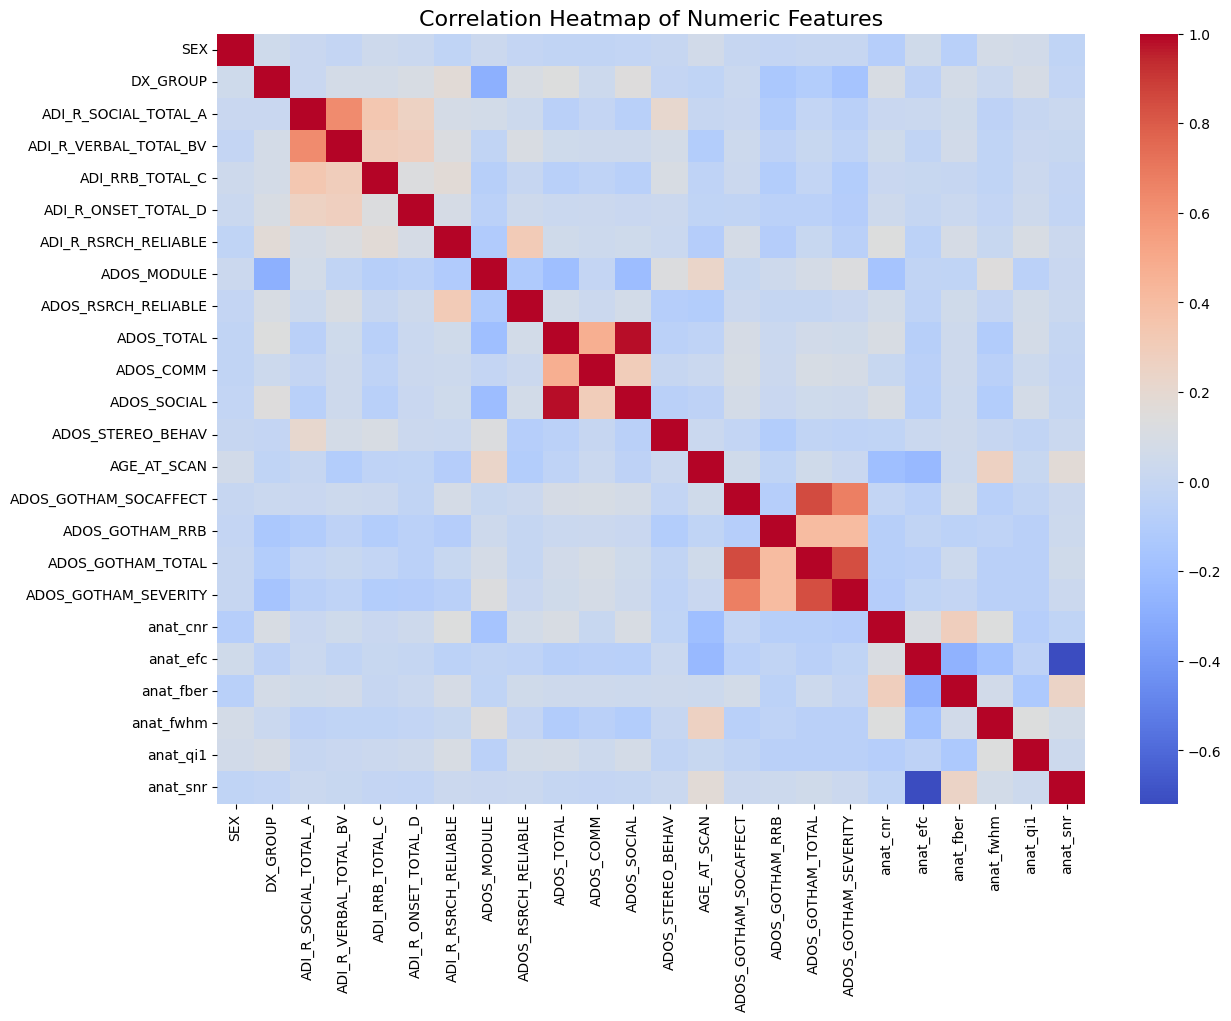

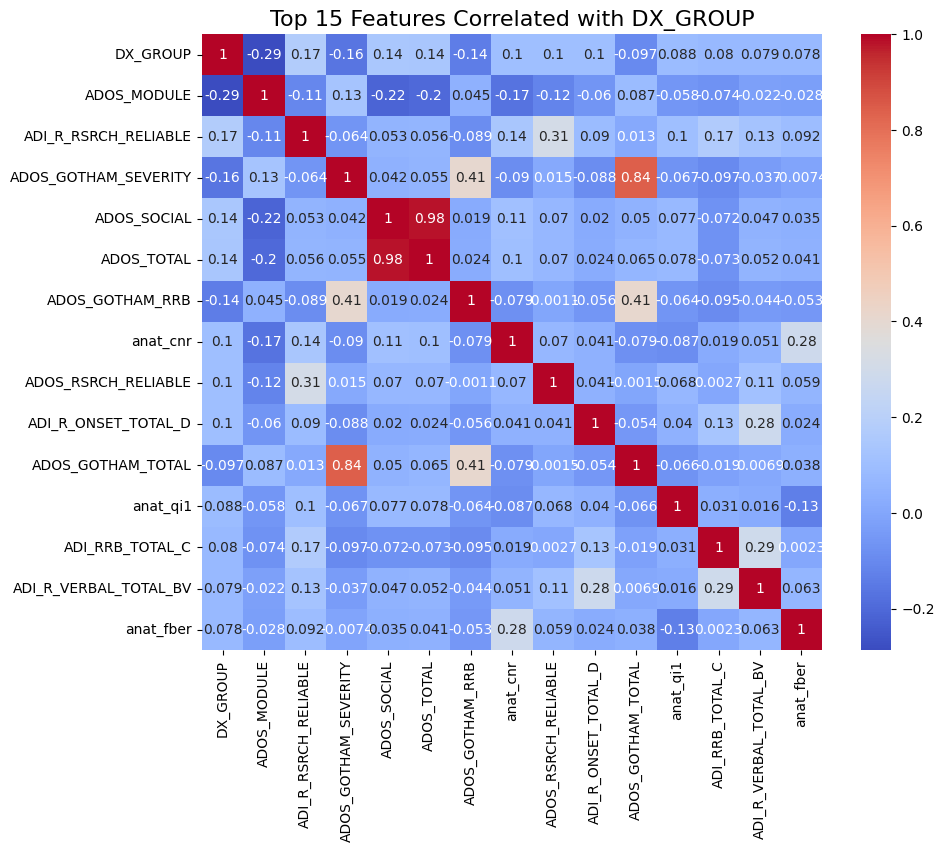

In [9]:
# Plot of Correlation btw col's:


# Select only numeric columns (since correlation works only on numeric data)
numeric_df = clinical_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr = numeric_df.corr()

# Show top correlations with DX_GROUP
print("Correlation with DX_GROUP:")
print(corr['DX_GROUP'].sort_values(ascending=False))

# Plot heatmap for overall correlations
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

# Optional: zoom in on top 15 correlated features with DX_GROUP
top_features = corr['DX_GROUP'].abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(corr.loc[top_features, top_features], annot=True, cmap="coolwarm", cbar=True)
plt.title("Top 15 Features Correlated with DX_GROUP", fontsize=16)
plt.show()

In [10]:
# Check Missing Values:

# Numerical summary of the missing col's
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by="Missing %", ascending=False)

print("Missing Values Summary:")
print(missing_summary.head(50))

Missing Values Summary:
                       Missing Count  Missing %
SEX                                0        0.0
DX_GROUP                           0        0.0
ADI_R_SOCIAL_TOTAL_A               0        0.0
ADI_R_VERBAL_TOTAL_BV              0        0.0
ADI_RRB_TOTAL_C                    0        0.0
ADI_R_ONSET_TOTAL_D                0        0.0
ADI_R_RSRCH_RELIABLE               0        0.0
ADOS_MODULE                        0        0.0
ADOS_RSRCH_RELIABLE                0        0.0
ADOS_TOTAL                         0        0.0
ADOS_COMM                          0        0.0
ADOS_SOCIAL                        0        0.0
ADOS_STEREO_BEHAV                  0        0.0
AGE_AT_SCAN                        0        0.0
ADOS_GOTHAM_SOCAFFECT              0        0.0
ADOS_GOTHAM_RRB                    0        0.0
ADOS_GOTHAM_TOTAL                  0        0.0
ADOS_GOTHAM_SEVERITY               0        0.0
anat_cnr                           0        0.0
anat_efc        

In [11]:

# # -----------------------
# # Visual summary (bar plot)
# # -----------------------
# plt.figure(figsize=(12, 6))
# missing_summary['Missing %'].head(50).plot(kind='bar', color="red")
# plt.title("Top 50 Columns with Missing Values (%)")
# plt.ylabel("Percentage Missing")
# plt.show()

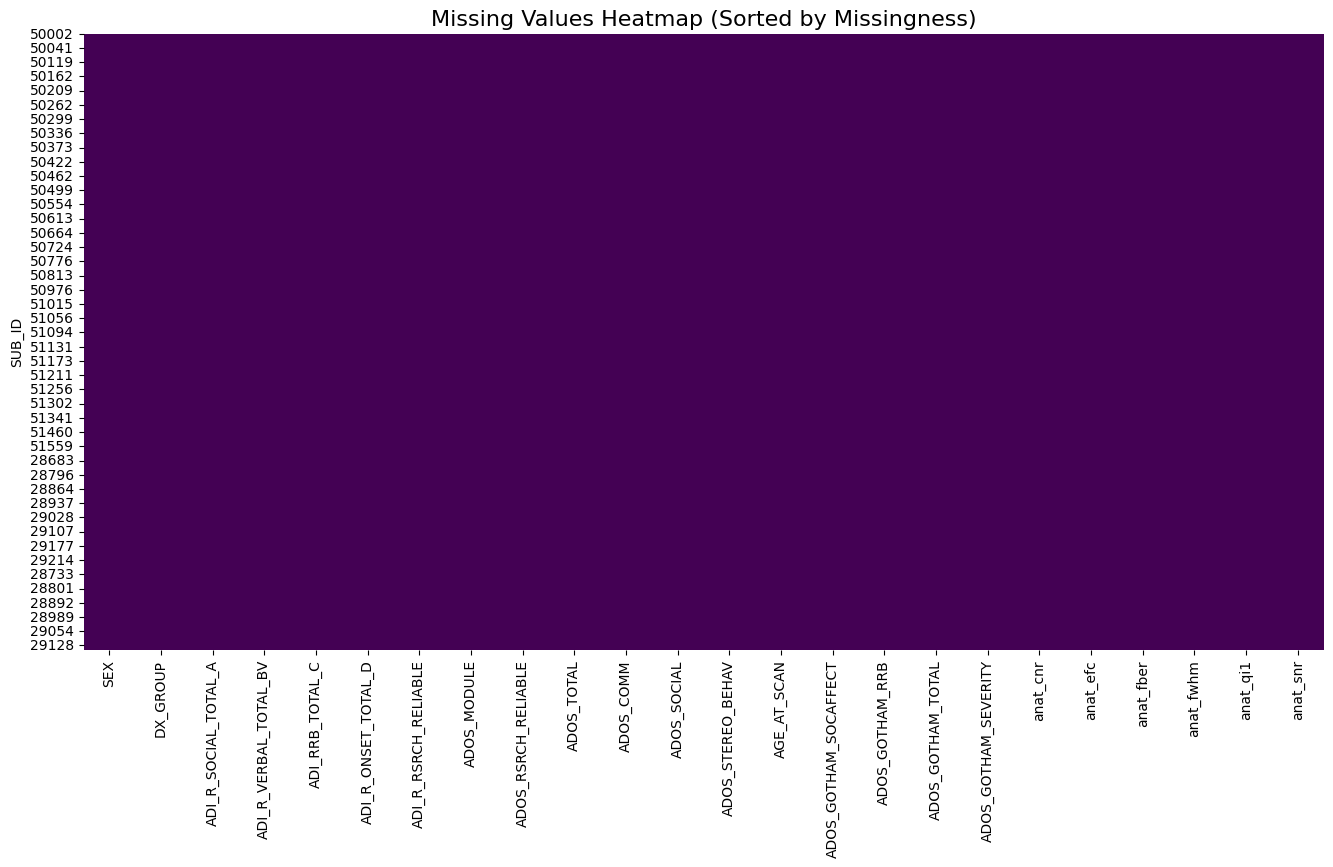

In [12]:
# Sort columns by % of missing values
missing_order = df.isnull().sum().sort_values(ascending=False).index

plt.figure(figsize=(16, 8))
sns.heatmap(df[missing_order].isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Sorted by Missingness)", fontsize=16)
plt.show()


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602 entries, 50002 to 29225
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEX                    1602 non-null   int64  
 1   DX_GROUP               1602 non-null   float64
 2   ADI_R_SOCIAL_TOTAL_A   1602 non-null   float64
 3   ADI_R_VERBAL_TOTAL_BV  1602 non-null   float64
 4   ADI_RRB_TOTAL_C        1602 non-null   float64
 5   ADI_R_ONSET_TOTAL_D    1602 non-null   float64
 6   ADI_R_RSRCH_RELIABLE   1602 non-null   float64
 7   ADOS_MODULE            1602 non-null   float64
 8   ADOS_RSRCH_RELIABLE    1602 non-null   float64
 9   ADOS_TOTAL             1602 non-null   float64
 10  ADOS_COMM              1602 non-null   float64
 11  ADOS_SOCIAL            1602 non-null   float64
 12  ADOS_STEREO_BEHAV      1602 non-null   float64
 13  AGE_AT_SCAN            1602 non-null   float64
 14  ADOS_GOTHAM_SOCAFFECT  1602 non-null   float64
 15  ADOS

In [14]:
df.describe()

SEX     DX_GROUP  ADI_R_SOCIAL_TOTAL_A  ADI_R_VERBAL_TOTAL_BV  \
count  1602.000000  1602.000000           1602.000000            1602.000000   
mean      0.841448     0.500000             13.623416              14.159914   
std       0.365372     0.500156             23.294409              18.283886   
min       0.000000     0.000000            -75.545276             -80.319727   
25%       1.000000     0.000000             -1.537239               6.296503   
50%       1.000000     0.500000              9.968850              16.000000   
75%       1.000000     1.000000             24.000000              19.820835   
max       1.000000     1.000000            122.511600             101.897955   

       ADI_RRB_TOTAL_C  ADI_R_ONSET_TOTAL_D  ADI_R_RSRCH_RELIABLE  \
count      1602.000000          1602.000000           1602.000000   
mean          4.654925             2.824502              0.857721   
std          10.326966             5.827675              1.232945   
min         -37.758489           -20.881235             -3.955128   
25%          -3.864687            -0.146172             -0.213913   
50%           4.765183             3.000000              1.000000   
75%           8.005596             4.764252              1.534425   
max          51.168442            36.363769              7.453733   

       ADOS_MODULE  ADOS_RSRCH_RELIABLE   ADOS_TOTAL  ...  \
count  1602.000000          1602.000000  1602.000000  ...   
mean      3.149687             1.019079    12.537240  ...   
std       1.510286             1.027766     4.520037  ...   
min      -3.264535            -3.074915    -2.060750  ...   
25%       1.835572             0.965558    10.000000  ...   
50%       3.000000             1.000000    12.840066  ...   
75%       4.000000             1.582263    15.716160  ...   
max       9.498199             4.867960    26.986239  ...   

       ADOS_GOTHAM_SOCAFFECT  ADOS_GOTHAM_RRB  ADOS_GOTHAM_TOTAL  \
count            1602.000000      1602.000000        1602.000000   
mean               10.909056         4.206830          13.877885   
std                20.021611        10.523019          21.593267   
min              -101.807775       -42.515913         -87.036634   
25%                 6.000000         1.000000           7.901436   
50%                10.503965         3.000000          12.000000   
75%                15.000000        11.697888          19.440971   
max                93.016611        44.752703         100.505547   

       ADOS_GOTHAM_SEVERITY     anat_cnr     anat_efc    anat_fber  \
count           1602.000000  1602.000000  1602.000000  1602.000000   
mean               8.641789    11.956163     1.950689    65.058554   
std               11.717453     4.974324     9.544269   133.783483   
min              -40.368013   -21.591433  -217.560433  -868.006299   
25%                4.657641     9.682799     0.814118     5.071422   
50%                7.000000    11.116011     1.629580    11.052802   
75%               16.637202    14.884755     2.692276    86.717226   
max               53.490246    51.691800    34.328045  1734.146859   

         anat_fwhm     anat_qi1     anat_snr  
count  1602.000000  1602.000000  1602.000000  
mean      3.543222     0.073611    37.356411  
std       0.565403     0.044924   239.606556  
min       2.533930    -0.212111 -1890.773381  
25%       3.243109     0.051057    13.504259  
50%       3.457611     0.065047    16.045425  
75%       3.594745     0.088258    18.865172  
max       6.106303     0.259048  5957.198529  

[8 rows x 24 columns]

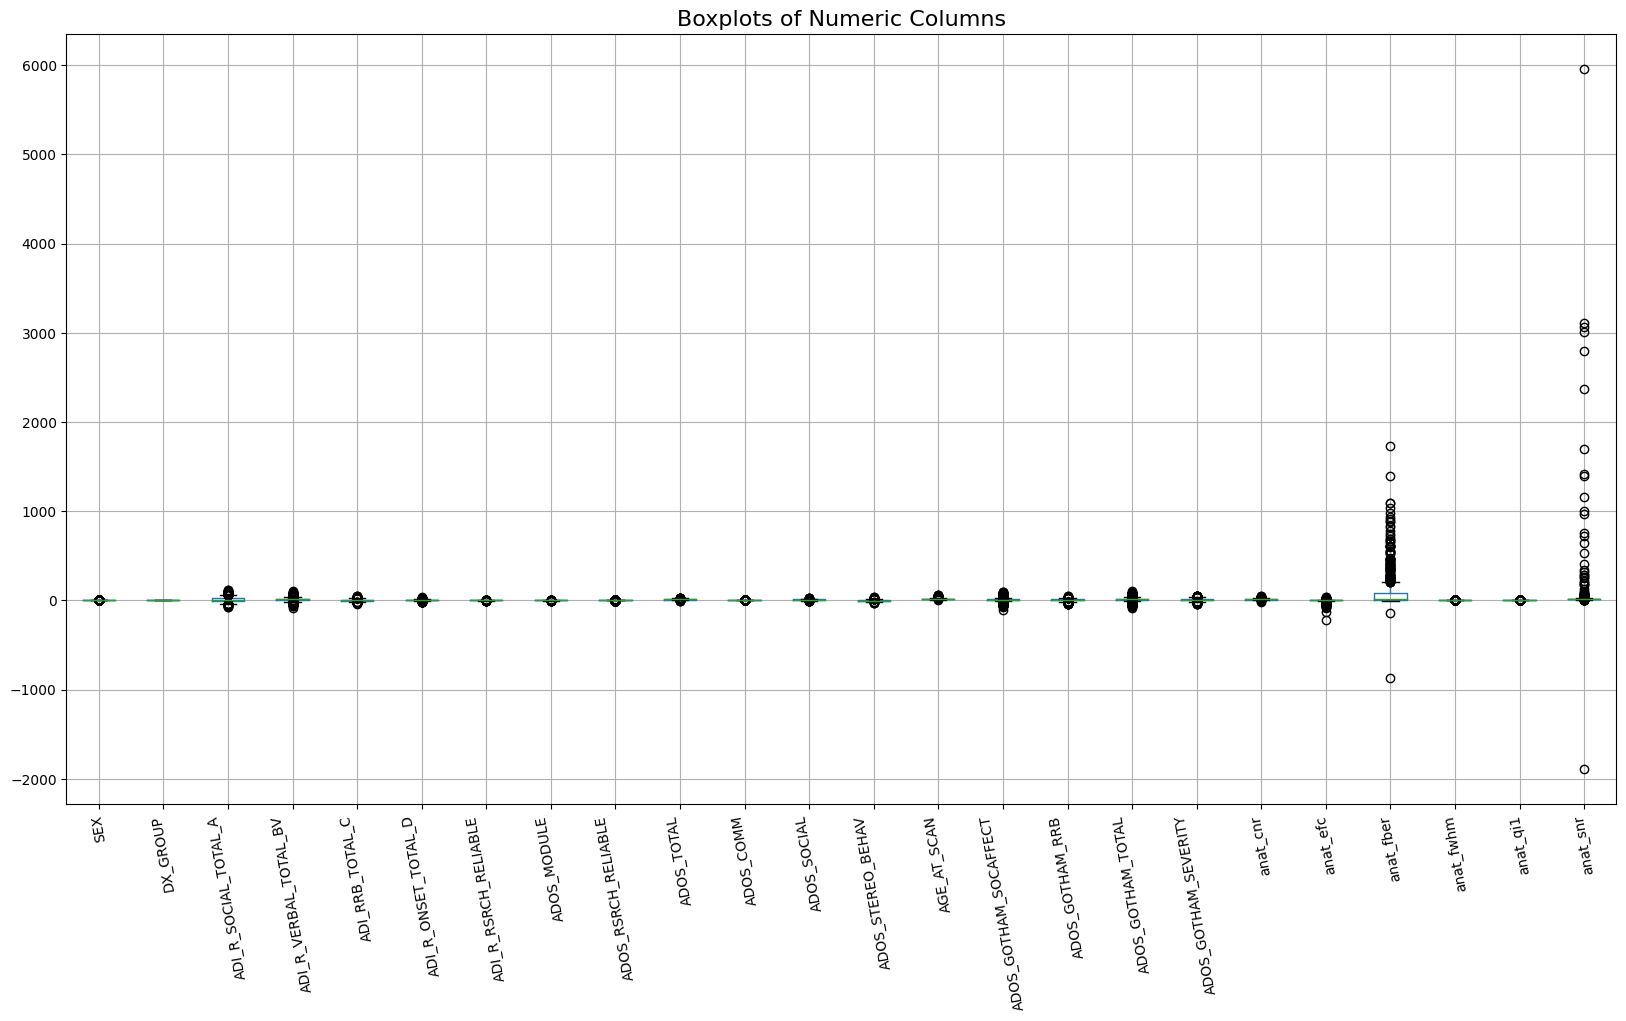

In [15]:
# Boxplot for each numeric column
plt.figure(figsize=(20, 10))
df.boxplot(rot=100)
plt.title("Boxplots of Numeric Columns", fontsize=16)
plt.show()

**Check distribution**

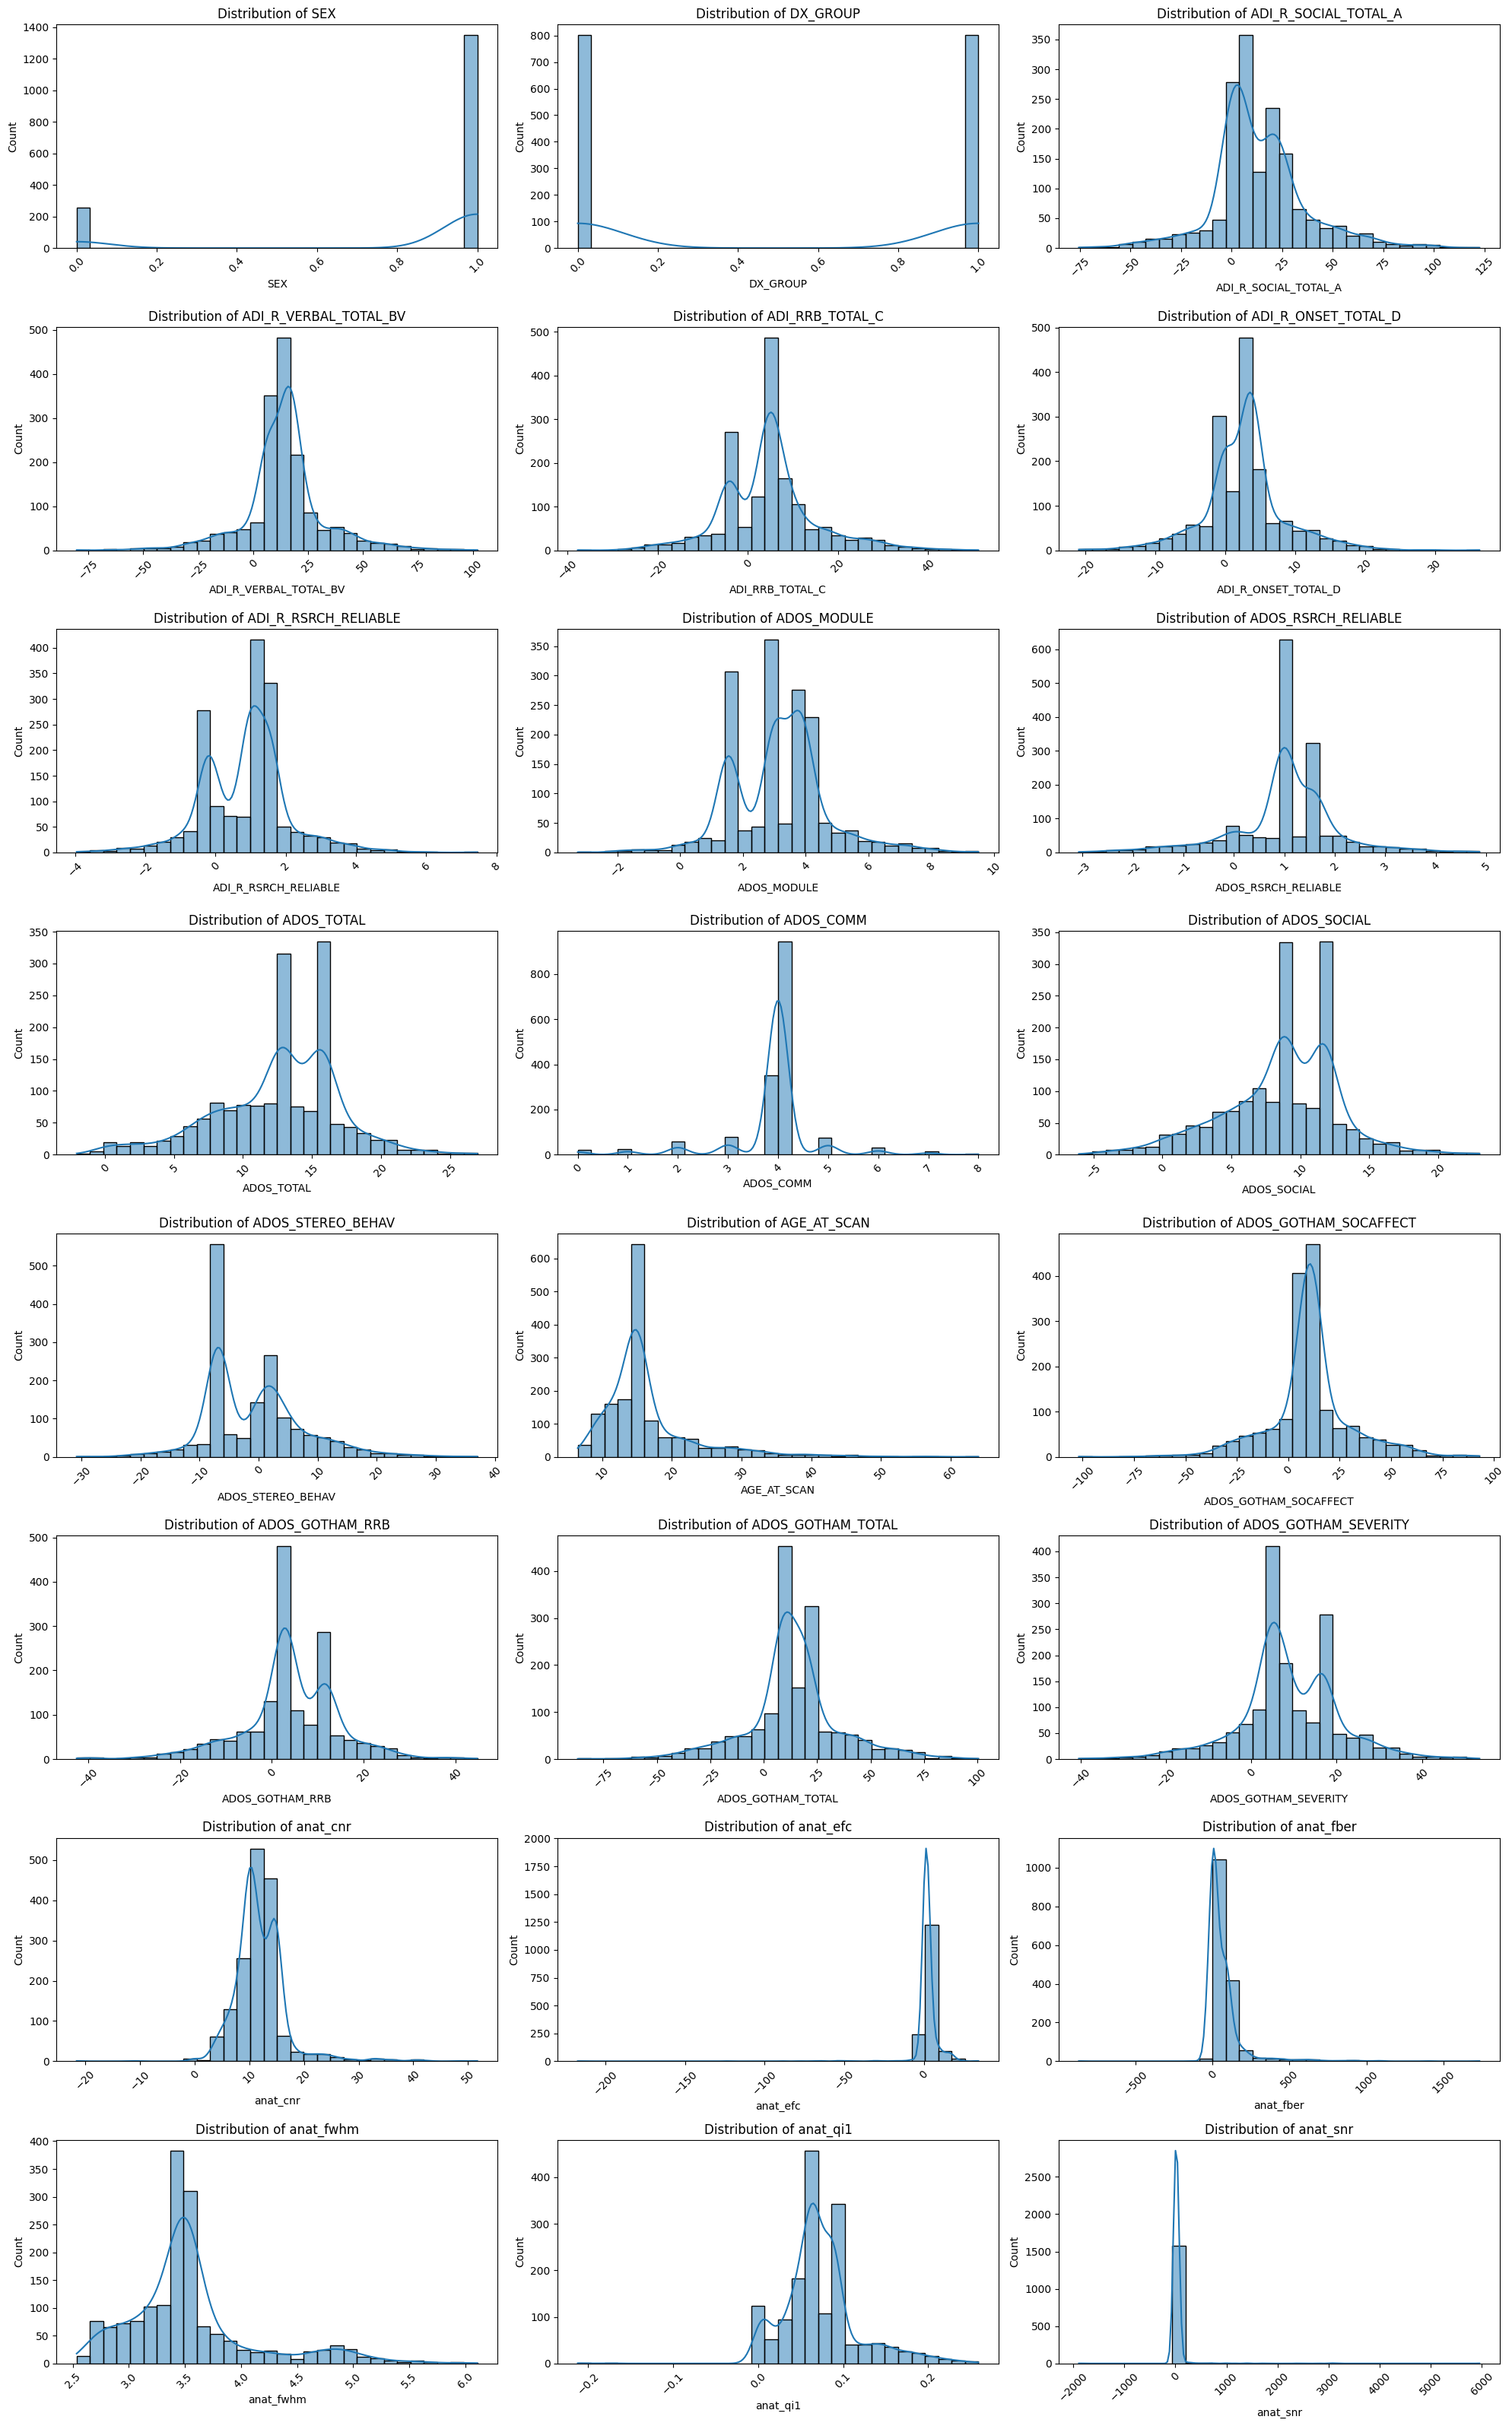

In [16]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

num_cols = len(numeric_cols)
n_cols = 3   # how many plots per row
n_rows = math.ceil(num_cols / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(numeric_cols):
    sns.histplot(df[column].replace([np.inf, -np.inf], np.nan).dropna(), 
                 kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots if grid is larger than number of columns
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Skewed Distribution (negative and positive)**

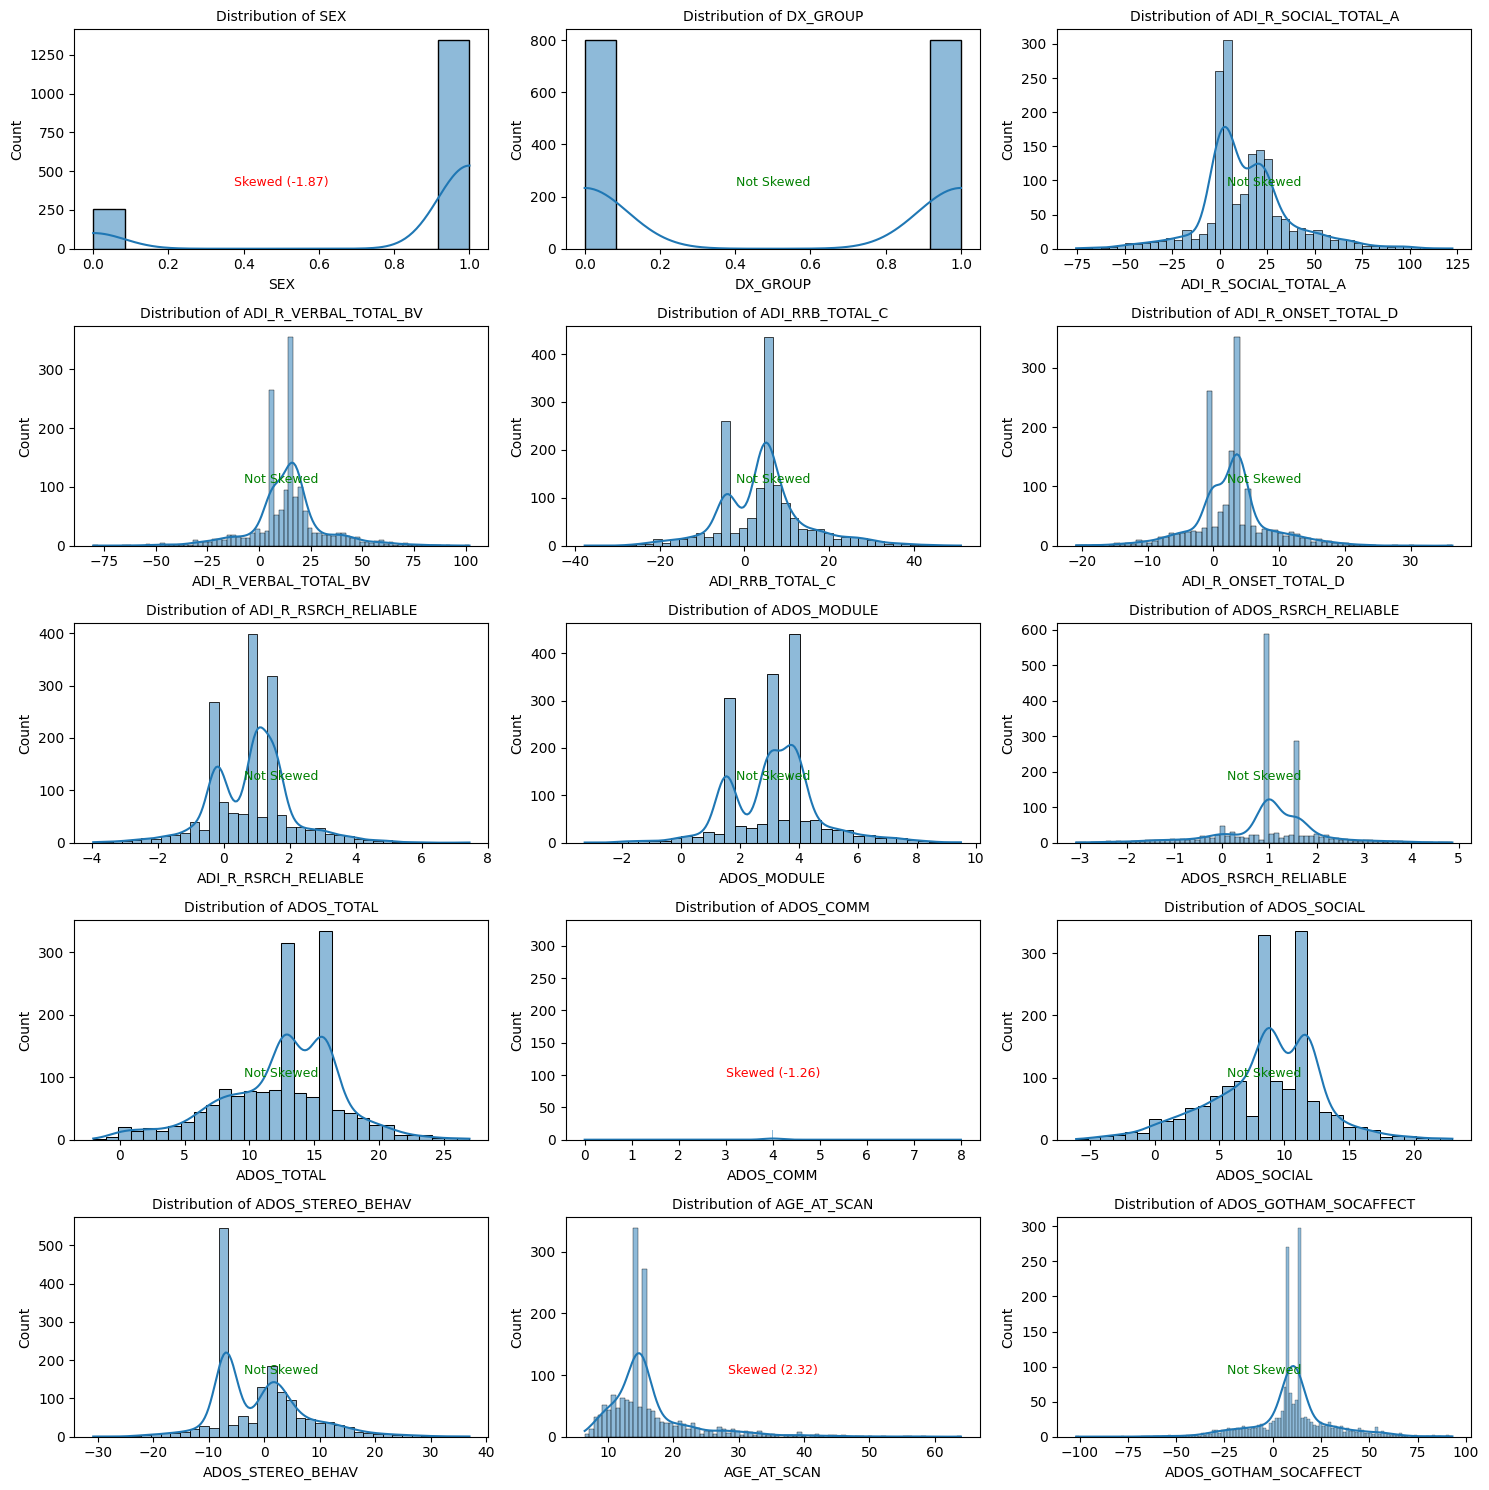

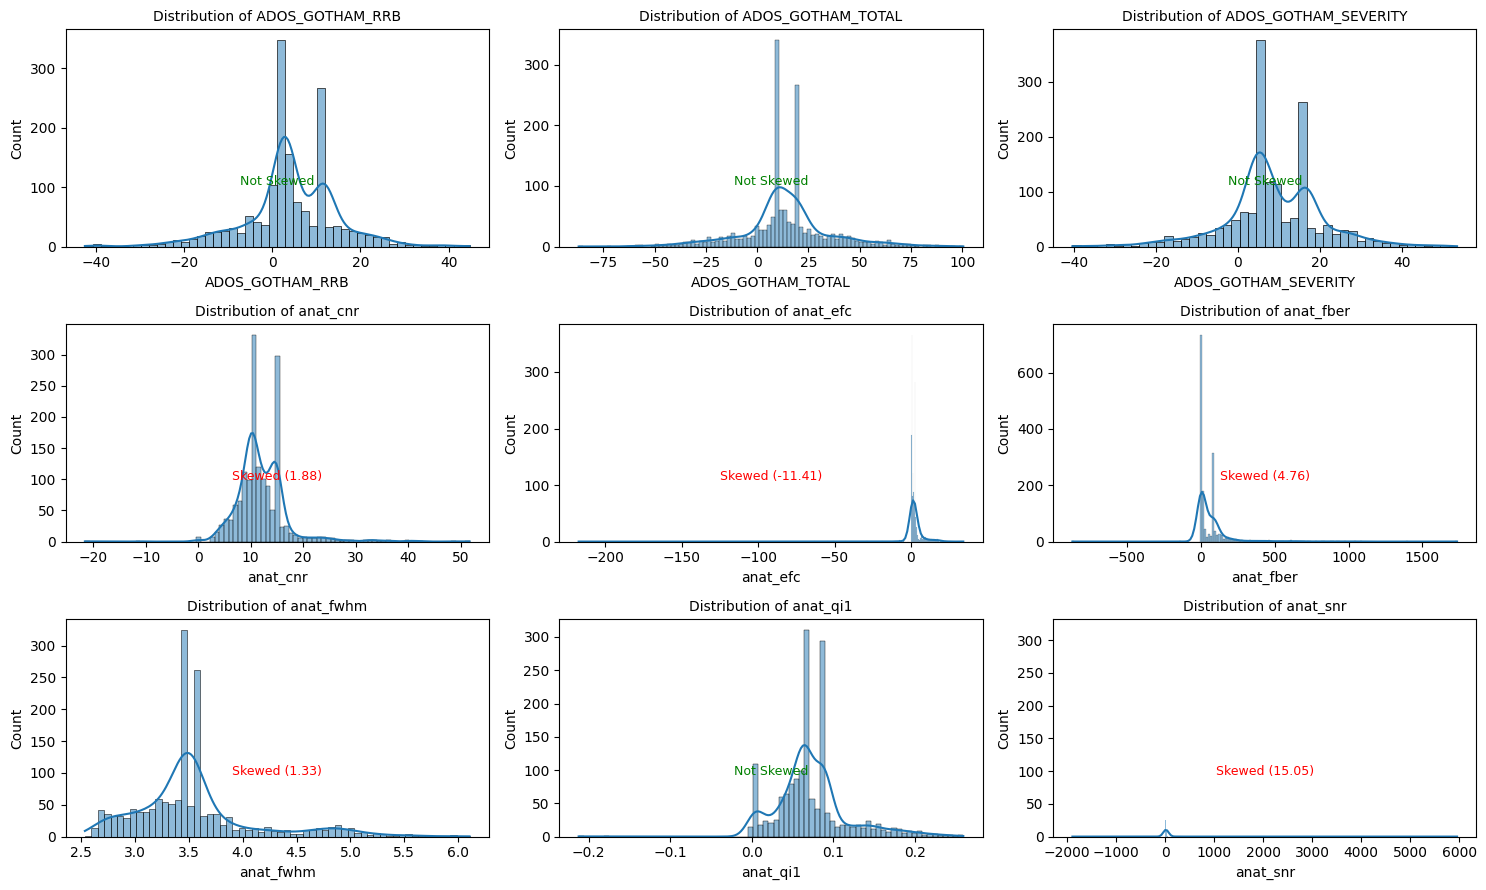

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

num_cols = len(df.columns)
cols_per_row = 3      # number of plots per row
batch_size = 15       # number of plots per figure (adjust for readability)

for batch_start in range(0, num_cols, batch_size):
    batch_cols = df.columns[batch_start:batch_start+batch_size]
    num_plots = len(batch_cols)
    rows = int(np.ceil(num_plots / cols_per_row))

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i, column in enumerate(batch_cols):
        ax = axes[i]

        # Skip non-numeric columns
        if np.issubdtype(df[column].dtype, np.number):
            sns.histplot(df[column].dropna(), kde=True, ax=ax)

            # Check skewness
            skewness = stats.skew(df[column].dropna())
            if skewness < -1 or skewness > 1:
                ax.text(0.5, 0.3, f"Skewed ({skewness:.2f})",
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=9, color='red')
            else:
                ax.text(0.5, 0.3, f"Not Skewed",
                        ha='center', va='center', transform=ax.transAxes,
                        fontsize=9, color='green')

            ax.set_title(f'Distribution of {column}', fontsize=10)
        else:
            ax.axis('off')  # hide non-numeric plots

    # Remove unused axes in this batch
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


**Checking Outliers**

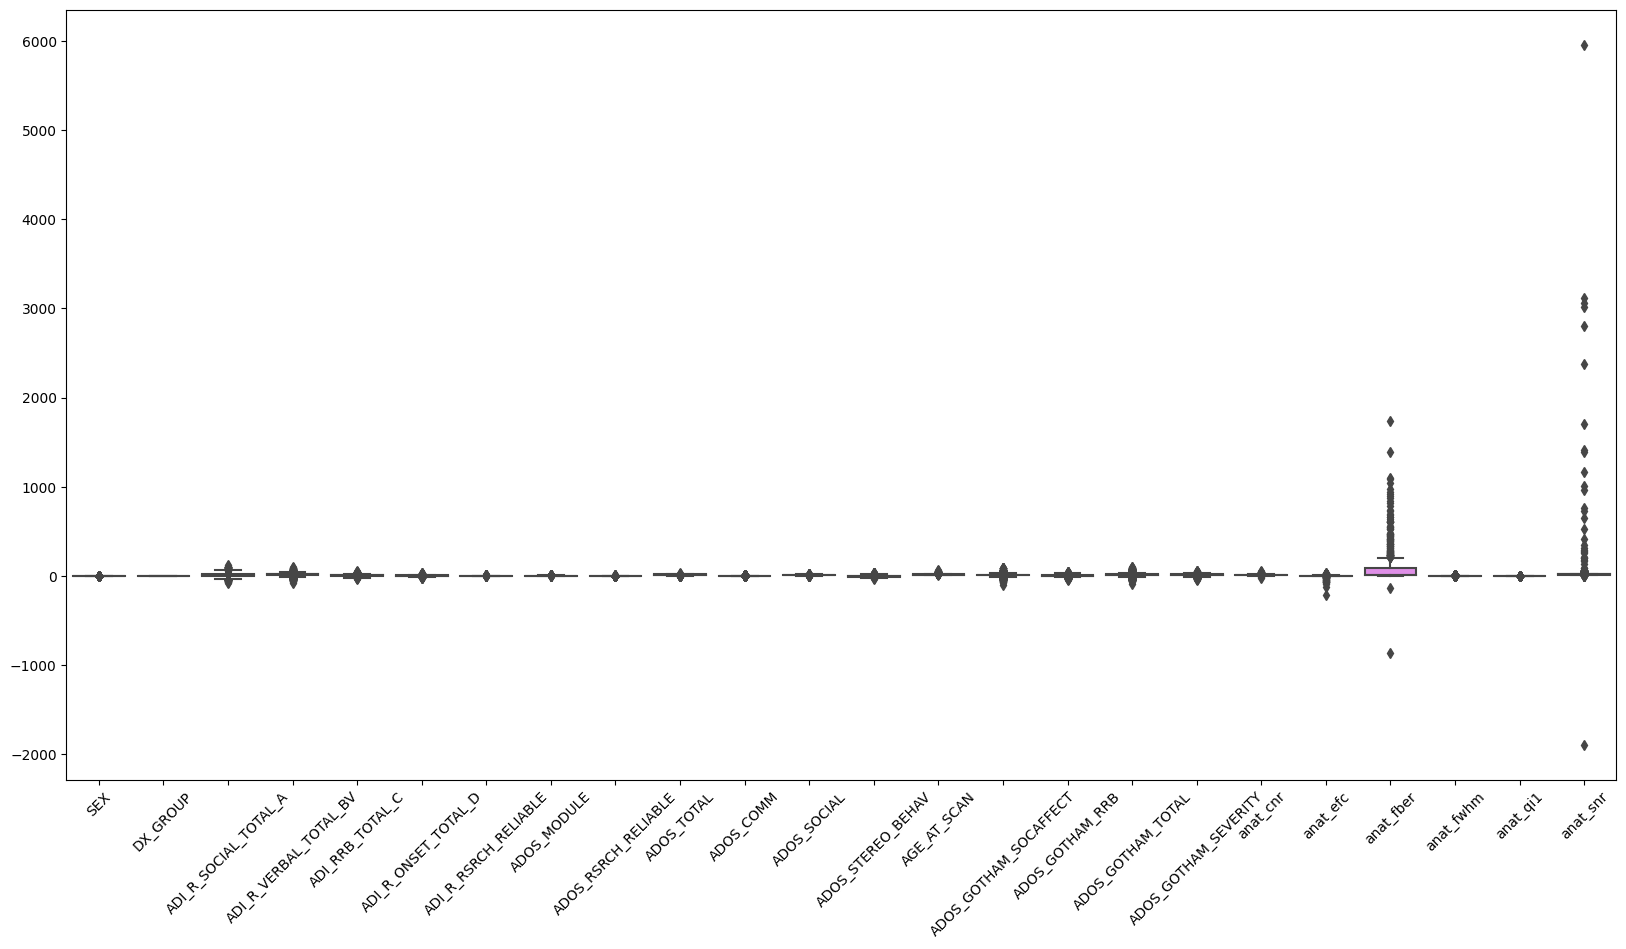

In [18]:
# Plot box plots for each numerical column
plt.figure(figsize=(20, 10))
sns.boxplot(data = df)
plt.xticks(rotation=45)
plt.show()

## **Data Analysis Images Dataset (JPG's)**

In [19]:
import os
from PIL import Image

# Count images
n_asd = len(os.listdir(ASD_DIR))
n_non_asd = len(os.listdir(NON_ASD_DIR))
print("ASD images:", n_asd)
print("Non-ASD images:", n_non_asd)


ASD images: 801
Non-ASD images: 801


Image size: (320, 220)


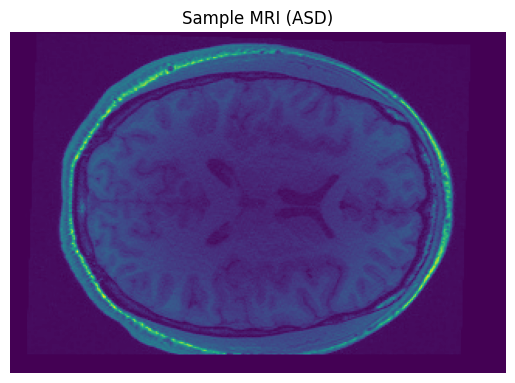

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = "/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD/28679.jpg"

# Open with PIL
img = Image.open(img_path)
print("Image size:", img.size)

# Display a sample img inside notebook
plt.imshow(img)
plt.axis("off")
plt.title("Sample MRI (ASD)")
plt.show()


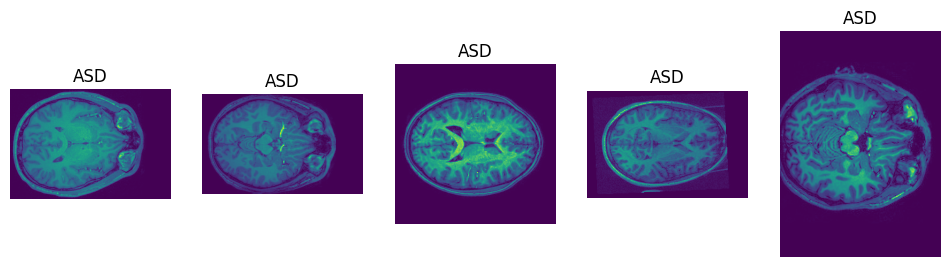

In [21]:
import glob
import random

asd_imgs = glob.glob("/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD/*.jpg")

plt.figure(figsize=(12,6))
for i, path in enumerate(random.sample(asd_imgs, 5)):
    img = Image.open(path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("ASD")
plt.show()


In [22]:
# =======================
#  Basic Stats
# =======================
asd_files = glob.glob(os.path.join(ASD_DIR, "*.jpg"))
non_asd_files = glob.glob(os.path.join(NON_ASD_DIR, "*.jpg"))

print(f"Number of ASD images: {len(asd_files)}")
print(f"Number of Non-ASD images: {len(non_asd_files)}")

# Check image dimensions for a few random samples
dims = []
for path in random.sample(asd_files + non_asd_files, 100):
    img = Image.open(path)
    dims.append(img.size)

dims_df = pd.DataFrame(dims, columns=["Width","Height"])
print(dims_df.describe())


Number of ASD images: 801
Number of Non-ASD images: 801
            Width    Height
count  100.000000  100.0000
mean   260.220000  178.5300
std     71.940292   45.0157
min    132.000000  106.0000
25%    240.000000  160.0000
50%    256.000000  160.0000
75%    256.000000  196.7500
max    480.000000  256.0000


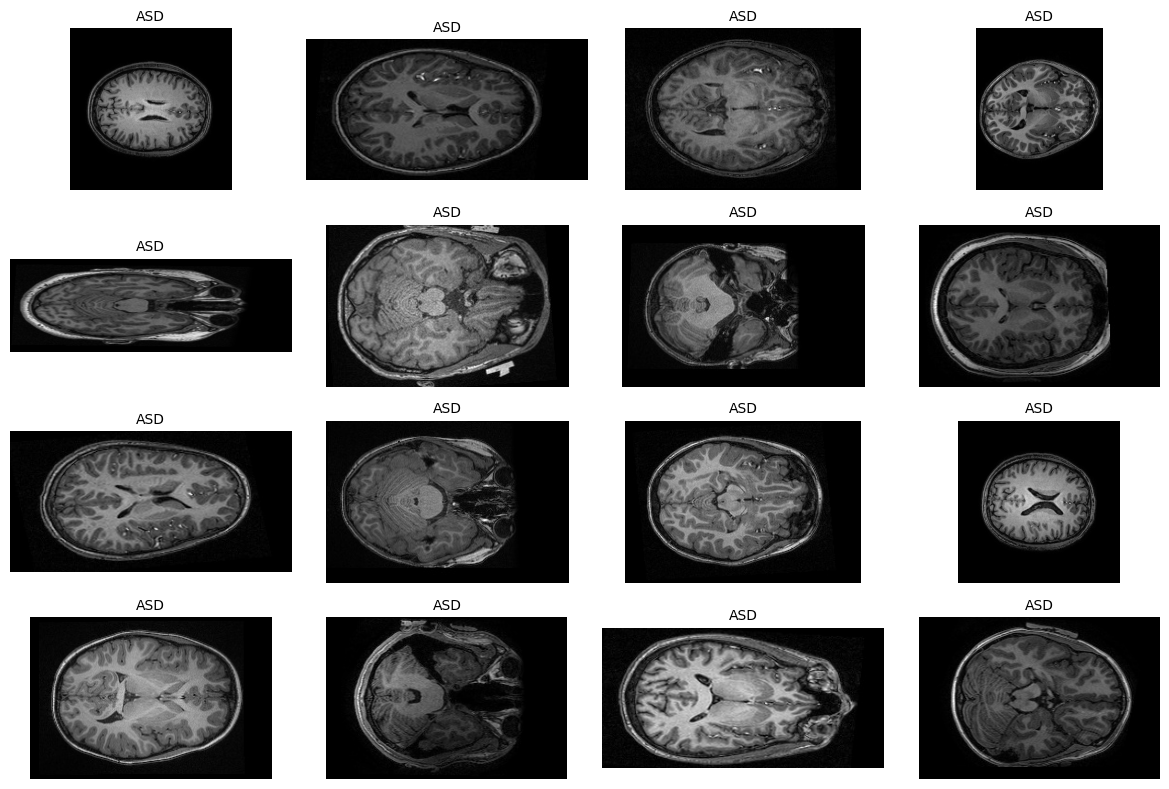

In [23]:

# =======================
# 5) Grid of Random Subjects
# =======================
plt.figure(figsize=(12,8))
all_samples = random.sample(asd_files, 8) + random.sample(non_asd_files, 8)
for i, path in enumerate(all_samples):
    img = Image.open(path)
    plt.subplot(4,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    label = "ASD" if "ASD" in path else "Non-ASD"
    plt.title(label, fontsize=10)
plt.tight_layout()
plt.show()

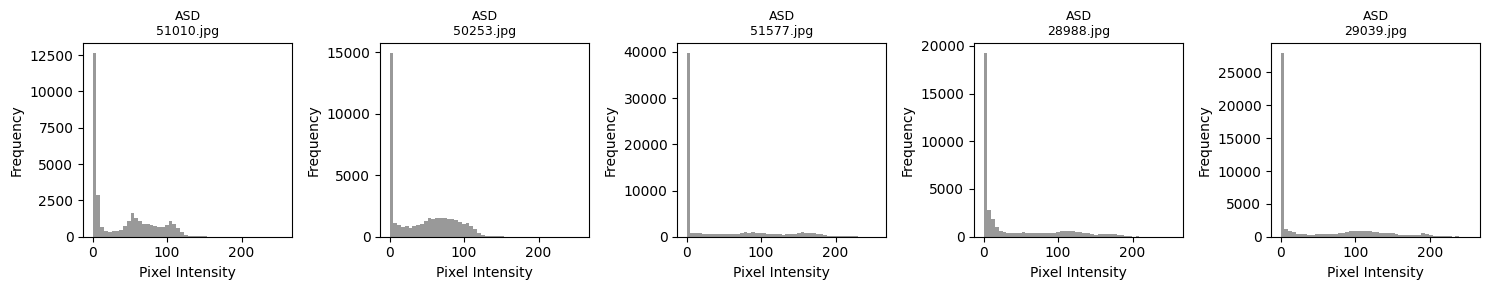

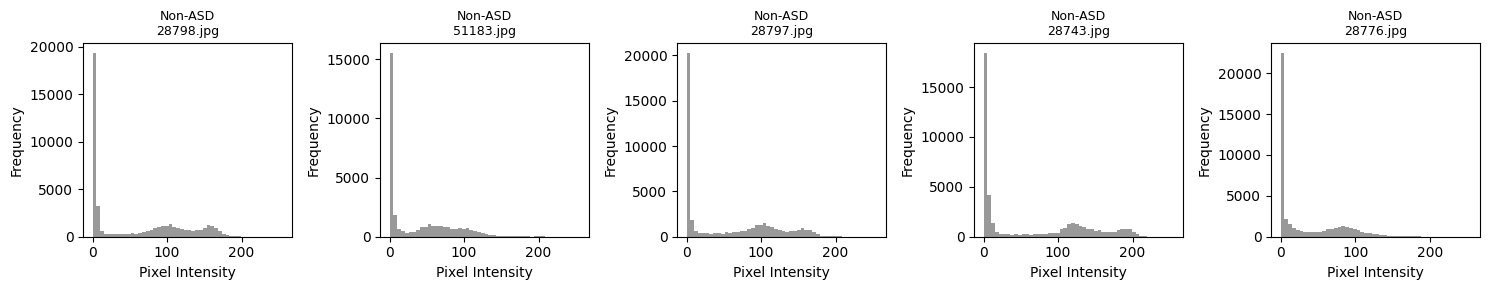

In [24]:
# =======================
#  Pixel Intensity Analysis
# =======================
import numpy as np

def plot_intensity_histograms(file_list, label, n=5):
    plt.figure(figsize=(15,3))
    for i, path in enumerate(random.sample(file_list, n)):
        img = Image.open(path).convert("L")  # grayscale
        arr = np.array(img)
        
        plt.subplot(1,n,i+1)
        plt.hist(arr.ravel(), bins=50, color="gray", alpha=0.8)
        plt.title(f"{label}\n{os.path.basename(path)}", fontsize=9)
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot histograms for random ASD & Non-ASD
plot_intensity_histograms(asd_files, "ASD", n=5)
plot_intensity_histograms(non_asd_files, "Non-ASD", n=5)

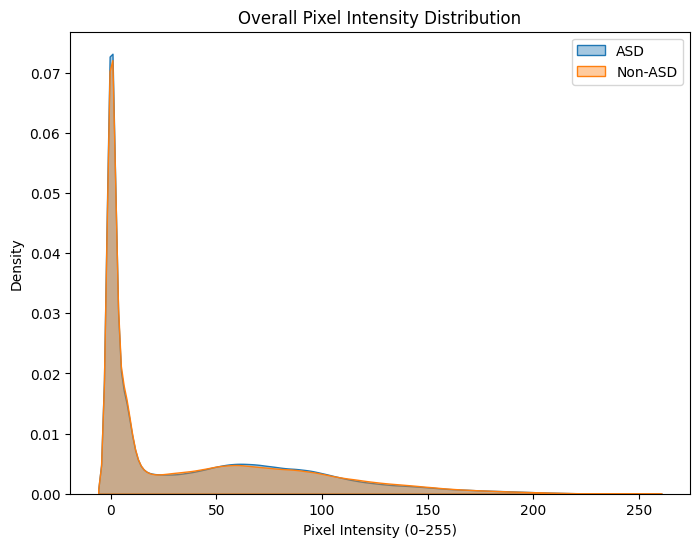

In [25]:
# =======================
#   Average Intensity Distribution
# =======================
def compute_intensity_distribution(file_list, n=200):
    all_vals = []
    for path in random.sample(file_list, min(len(file_list), n)):
        img = Image.open(path).convert("L")
        arr = np.array(img).ravel()
        all_vals.extend(arr)
    return np.array(all_vals)

asd_intensity = compute_intensity_distribution(asd_files)
non_intensity = compute_intensity_distribution(non_asd_files)

plt.figure(figsize=(8,6))
sns.kdeplot(asd_intensity, label="ASD", fill=True, alpha=0.4)
sns.kdeplot(non_intensity, label="Non-ASD", fill=True, alpha=0.4)
plt.title("Overall Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Density")
plt.legend()
plt.show()

            Width      Height
count  200.000000  200.000000
mean   260.310000  178.680000
std     59.884008   45.194361
min    132.000000  106.000000
25%    256.000000  160.000000
50%    256.000000  160.000000
75%    256.000000  208.000000
max    480.000000  256.000000


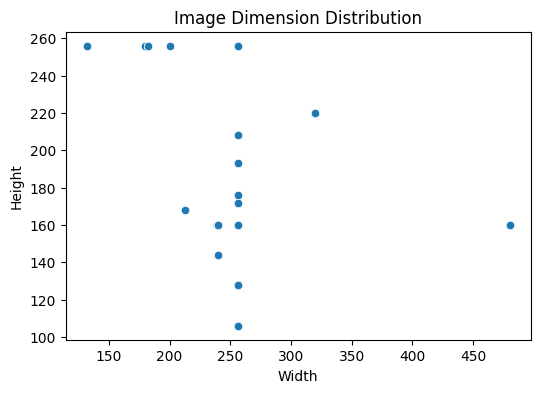

In [26]:
# -----------------------
#  Image Dimension Analysis
# -----------------------
dims = []
for path in random.sample(asd_files + non_asd_files, 200):
    img = Image.open(path)
    dims.append(img.size)

dims_df = pd.DataFrame(dims, columns=["Width","Height"])
print(dims_df.describe())

plt.figure(figsize=(6,4))
sns.scatterplot(data=dims_df, x="Width", y="Height")
plt.title("Image Dimension Distribution")
plt.show()

In [27]:
# -----------------------
#  Duplicate Detection
# -----------------------
def get_image_signature(path, size=(32,32)):
    img = Image.open(path).convert("L").resize(size)
    return np.array(img).ravel() / 255.0

sample_paths = random.sample(asd_files+non_asd_files, 500)  # subset for speed
signatures = np.array([get_image_signature(p) for p in sample_paths])
dists = pairwise_distances(signatures, metric="cosine")

# Find near-duplicates (cosine sim > 0.99)
duplicates = []
for i in range(len(sample_paths)):
    for j in range(i+1, len(sample_paths)):
        if 1 - dists[i,j] > 0.99:
            duplicates.append((sample_paths[i], sample_paths[j]))

print("Possible near-duplicates found:", len(duplicates))
if duplicates:
    print(duplicates[:5])  # show first few


Possible near-duplicates found: 0


In [28]:
ASD_DIR

'/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD'

In [29]:
NON_ASD_DIR

'/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/NON-ASD'

In [30]:
len(glob.glob(os.path.join(ASD_DIR, "*.jpg"))) ,  len(glob.glob(os.path.join(NON_ASD_DIR, "*.jpg")))

(801, 801)

In [31]:
# 2) Build image dataframe by scanning folders and extracting SUB_ID from filenames
asd_files = glob.glob(os.path.join(ASD_DIR, "*.jpg"))
non_asd_files = glob.glob(os.path.join(NON_ASD_DIR, "*.jpg"))

img_df = pd.DataFrame({
    'FILE_PATH': asd_files + non_asd_files,
    'DX_GROUP': [1]*len(asd_files) + [0]*len(non_asd_files)
})

In [32]:
img_df

FILE_PATH  DX_GROUP
0     /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
1     /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
2     /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
3     /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
4     /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
...                                                 ...       ...
1597  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
1598  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
1599  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
1600  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
1601  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0

[1602 rows x 2 columns]

In [33]:
img_df['FILE_PATH'][0]

'/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD/50478.jpg'

In [34]:
# extract SUB_ID assuming filename like '<SUB_ID>.jpg'
img_df['SUB_ID'] = img_df['FILE_PATH'].apply(lambda x: int(os.path.basename(x).split('.')[0]))
img_df.set_index('SUB_ID', inplace=True)
img_df

FILE_PATH  DX_GROUP
SUB_ID                                                             
50478   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
29112   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
51029   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
50183   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
50005   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1
...                                                   ...       ...
50116   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
28960   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
50656   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
51273   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0
51253   /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0

[1602 rows x 2 columns]

In [35]:
# 3) Merge clinical and image tables
merged_df = img_df.join(
    clinical_df.drop(columns=['DX_GROUP']),  # drop duplicate
    how='inner'
)

merged_df = merged_df.sample(frac=1, random_state=RANDOM_STATE).reset_index()
merged_df

SUB_ID                                          FILE_PATH  DX_GROUP  \
0      50024  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1   
1      29045  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   
2      29109  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1   
3      29162  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1   
4      50614  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         1   
...      ...                                                ...       ...   
1597   29085  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   
1598   50688  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   
1599   28950  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   
1600   51344  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   
1601   50731  /kaggle/input/abide-jpgs-verion-03/ABIDE MRI J...         0   

      SEX  ADI_R_SOCIAL_TOTAL_A  ADI_R_VERBAL_TOTAL_BV  ADI_RRB_TOTAL_C  \
0       1             19.000000              11.000000         4.000000   
1       1             -1.537239               6.296503        -4.176392   
2       0              4.579743              16.512834         4.765183   
3       0              4.579743              16.512834         4.765183   
4       1             26.000000              20.000000         4.000000   
...   ...                   ...                    ...              ...   
1597    1             -1.537239               6.296503        -4.176392   
1598    1            -15.872729             -31.755522         7.224118   
1599    1             -1.537239               6.296503        -4.176392   
1600    1            -14.922023               5.057276        -1.320383   
1601    1             32.800244               6.303631         4.400979   

      ADI_R_ONSET_TOTAL_D  ADI_R_RSRCH_RELIABLE  ADOS_MODULE  ...  \
0                3.000000              1.000000     4.000000  ...   
1               -0.146172             -0.230726     3.687870  ...   
2                3.783993              1.534425     1.523605  ...   
3                3.783993              1.534425     1.523605  ...   
4                3.000000              1.000000     2.000000  ...   
...                   ...                   ...          ...  ...   
1597            -0.146172             -0.230726     3.687870  ...   
1598            -0.293562             -0.473217     3.448875  ...   
1599            -0.146172             -0.230726     3.687870  ...   
1600             2.671042              0.724302     3.233349  ...   
1601             8.295797             -0.725282     5.381721  ...   

      ADOS_GOTHAM_SOCAFFECT  ADOS_GOTHAM_RRB  ADOS_GOTHAM_TOTAL  \
0                 15.291679        44.752703          52.316793   
1                  8.308471        11.697888          19.440971   
2                 13.258180         2.782573           9.160288   
3                 13.258180         2.782573           9.160288   
4                 13.000000         2.000000          15.000000   
...                     ...              ...                ...   
1597               8.308471        11.697888          19.440971   
1598              25.231737        -8.447275          13.410169   
1599               8.308471        11.697888          19.440971   
1600              13.796451        16.210885          29.158024   
1601              31.446112        37.642535          64.641516   

      ADOS_GOTHAM_SEVERITY   anat_cnr  anat_efc   anat_fber  anat_fwhm  \
0                28.540054   6.840155  1.320027    7.542863   3.690417   
1                16.637202  10.202973  2.692276    5.071422   3.553689   
2                 4.657641  14.884755  0.814118   86.717226   3.457611   
3                 4.657641  14.884755  0.814118   86.717226   3.457611   
4                 9.000000  32.110417  0.904326  398.825717   4.750580   
...                    ...        ...       ...         ...        ...   
1597             16.637202  

In [36]:
merged_df['FILE_PATH'].duplicated().sum()

0

In [37]:
merged_df['SUB_ID'].duplicated().sum()

0

In [38]:
merged_df["DX_GROUP"].value_counts()

DX_GROUP
1    801
0    801
Name: count, dtype: int64

In [39]:
# Quick sanity
print("Total merged samples:", len(merged_df))

Total merged samples: 1602


In [40]:
# 4) Prepare clinical features (numerical) and scaler
numeric_cols = merged_df.select_dtypes(include=np.number).columns.tolist()
# numeric_cols includes 'SUB_ID', 'DX_GROUP', maybe other numeric clinicals; remove label and id
numeric_cols = [c for c in numeric_cols if c not in ['SUB_ID', 'DX_GROUP']]
print("Numeric clinical columns used:", numeric_cols)

Numeric clinical columns used: ['SEX', 'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_RSRCH_RELIABLE', 'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'AGE_AT_SCAN', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'anat_cnr', 'anat_efc', 'anat_fber', 'anat_fwhm', 'anat_qi1', 'anat_snr']


In [41]:
len(numeric_cols)

23

In [42]:
merged_df.columns

Index(['SUB_ID', 'FILE_PATH', 'DX_GROUP', 'SEX', 'ADI_R_SOCIAL_TOTAL_A',
       'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D',
       'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_RSRCH_RELIABLE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'AGE_AT_SCAN', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'anat_cnr', 'anat_efc',
       'anat_fber', 'anat_fwhm', 'anat_qi1', 'anat_snr'],
      dtype='object')

In [43]:
scaler = StandardScaler()
clin_values = merged_df[numeric_cols].fillna(0).values.astype(np.float32)
scaler.fit(clin_values)
clin_scaled = scaler.transform(clin_values)
clin_scaled

array([[ 0.43408215,  0.23088217, -0.17287906, ...,  0.26041755,
         2.2679856 , -0.12057661],
       [ 0.43408215, -0.6510313 , -0.43020758, ...,  0.01851835,
        -0.1906929 , -0.08358229],
       [-2.3037114 , -0.38835484,  0.12872837, ..., -0.15146337,
         0.32613355, -0.08896935],
       ...,
       [ 0.43408215, -0.6510313 , -0.43020758, ...,  0.01851835,
        -0.1906929 , -0.08358229],
       [ 0.43408215, -1.2258028 , -0.49800575, ...,  0.15547314,
         0.06373174, -0.05976251],
       [ 0.43408215,  0.82349443, -0.42981765, ..., -0.05091002,
        -0.34010422, -0.08634064]], dtype=float32)

In [44]:
# Save scaler for inference
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump({'scaler': scaler, 'numeric_cols': numeric_cols}, f)
print("Saved scaler to", SCALER_SAVE_PATH)


Saved scaler to clinical_scaler.pkl


In [45]:
# 5) Compose lists for tf.data
paths_list = merged_df['FILE_PATH'].astype(str).tolist()
clin_list = clin_scaled.tolist()
labels_list = merged_df['DX_GROUP'].astype(int).tolist()


---

## 4) Train/Test Split

### 📝 Explanation

We split into **train/test subsets** while stratifying by label (`DX_GROUP`) to ensure class balance.



In [46]:
# 6) Train/test split

from sklearn.model_selection import train_test_split
p_train, p_test, c_train, c_test, y_train, y_test = train_test_split(
    paths_list, clin_list, labels_list,
    test_size=0.2, random_state=RANDOM_STATE, stratify=labels_list
)


# # Step 1: Split into train + test
# p_train, p_temp, c_train, c_temp, y_train, y_temp = train_test_split(
#     paths_list, clin_list, labels_list,
#     test_size=0.2, random_state=RANDOM_STATE, stratify=labels_list
# )


In [ ]:
# len(p_train) , len(p_temp)

In [ ]:
# len(c_train), len(c_temp)

In [ ]:
# len(y_train), len(y_temp)

In [ ]:

# # Step 2: Split temp into validation + test
# p_val, p_test, c_val, c_test, y_val, y_test = train_test_split(
#     p_temp, c_temp, y_temp,
#     test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
# )

In [ ]:
# len(p_val), len(p_test)

In [ ]:
# len(c_val), len(c_test)

In [ ]:
# len(y_val), len(y_test)

In [ ]:
# len(p_train), len(p_test)

In [ ]:
# len(c_train), len(c_test)

In [ ]:
# len(y_train), len(y_test)



---

## 5) tf.data Pipeline

####  Explanation

We build an **efficient TensorFlow input pipeline**:

* Loads JPEG images from disk
* Resizes → normalizes pixel values
* Applies **data augmentation** (flip, brightness, contrast) to training only
* Combines image + clinical vector → `( (img, clin), label )`



In [47]:

# 7) tf.data parse & augmentation functions
AUTOTUNE = tf.data.AUTOTUNE

def _load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image

# augmentation as a function (applied only to training dataset)
def _augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # small rotation via affine isn't directly available as simple op; keep simple transforms
    return image


def make_dataset(paths, clin_vectors, labels, batch_size=32, training=False):
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    clin_ds = tf.data.Dataset.from_tensor_slices(np.array(clin_vectors, dtype=np.float32))
    labels_ds = tf.data.Dataset.from_tensor_slices(np.array(labels, dtype=np.int32))

    ds = tf.data.Dataset.zip((paths_ds, clin_ds, labels_ds))

    if training:
        ds = ds.shuffle(buffer_size=2048, seed=RANDOM_STATE)

    def _map_fn(path, clin, label):
        img = _load_and_preprocess_image(path)
        if training:
            img = _augment(img)
        return (img, clin), label

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [48]:

train_ds = make_dataset(p_train, c_train, y_train, batch_size=BATCH_SIZE, training=True)
val_ds = make_dataset(p_test, c_test, y_test, batch_size=BATCH_SIZE, training=False)


I0000 00:00:1758980790.413958      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [49]:
IMG_SIZE

(224, 224)

---

## 6) Hybrid Model Architecture


```
                MRI Image                         Clinical Data
               (ResNet50)                       (Numeric Features)
                  │                                      │
   ┌──────────────┘                                      │
   │      CNN extracts features                          │
   │              │                                      │
   │              │     ┌────────────────────────┐       │
   │              └────►│ Image Embedding (f_img)|       │
   │                    └────────────────────────┘       │
   │                                                     │
   │                         ┌──────────────────────┐    │
   │                         │ Clinical Emb (f_clin)│◄───│
   │                         └──────────────────────┘    │
   │                                                     │
   └───────────────► Concatenate [f_img, f_clin] ◄───────┘
                             │
                         Dense + Dropout
                             │
                        Sigmoid Neuron
                             │
                ┌────────────┴─────────────┐
                │ Probability (Ŷ= ASD prob)│
                └──────────────────────────┘
```



####  Explanation

The hybrid model combines **two branches**:

1. **Image branch (ResNet50)** → extracts spatial features from MRI slices.
   Output: high-level feature vector $\mathbf{f}_{img}$

2. **Clinical branch (Dense layer)** → transforms numeric clinical features into representation $\mathbf{f}_{clin}$.

3. **Concatenation**:

$$
\mathbf{f}_{combined} = \text{concat}(\mathbf{f}_{img}, \mathbf{f}_{clin})
$$

4. **Classification layer** applies a **sigmoid activation**:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

where $z$ is the output of the final dense neuron.

This yields a probability score $\hat{y} \in (0,1)$, interpreted as the probability of ASD.

 We freeze ResNet50 backbone for initial training.
   
   
   

---

### Loss Function

####  Explanation

We use **Binary Cross-Entropy (BCE)**:

$$
\mathcal{L}(y, \hat{y}) = - \big[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \big]
$$

where:

* $y \in \{0,1\}$ = ground truth label (0 = NON-ASD, 1 = ASD)
* $\hat{y}$ = predicted probability from the model

Minimizing BCE encourages the model to output high probability for correct class and low for incorrect class.



In [50]:
# 8) Build hybrid model (ResNet base + clinical branch)

# Image input
image_input = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='image_input')
clinical_input = Input(shape=(len(numeric_cols),), name='clinical_input')


resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)


# Use global pooling instead of flatten
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)


# Clinical branch
y = Dense(64, activation='relu')(clinical_input)
y = Dropout(0.3)(y)



# combine
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid', name='output')(z)

model = Model(inputs=[image_input, clinical_input], outputs=output)


# Freeze backbone initially
for layer in resnet_base.layers:
    layer.trainable = False


model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,155,009 (92.14 MB)

 Trainable params: 567,297 (2.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


---

## 7) Callbacks & Training

####  Explanation

We use:

* **ModelCheckpoint** → saves best `.keras` model by validation loss
* **EarlyStopping** → stops training if no improvement (patience=7)
* **ReduceLROnPlateau** → lowers LR when validation stalls

Also compute **class weights** to handle imbalance between ASD / NON-ASD.




In [51]:
# 9) Callbacks
callbacks = [
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, save_weights_only=False),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
]

In [52]:
# 10) Optionally compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print('Class weights:', class_weight_dict)

Class weights: {0: 1.00078125, 1: 0.999219968798752}


` Training  `

In [53]:
# 11) Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Save final model (saved by checkpoint already, but ensure export)
model.save(MODEL_SAVE_PATH)
print('Saved model to', MODEL_SAVE_PATH)


Epoch 1/40


I0000 00:00:1758980810.621199     104 service.cc:148] XLA service 0x7f4fe4003440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758980810.622000     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758980812.267512     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/41 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4983 - loss: 0.7928  

I0000 00:00:1758980817.173043     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 350ms/step - accuracy: 0.5241 - loss: 0.7456 - val_accuracy: 0.4860 - val_loss: 0.6842 - learning_rate: 1.0000e-04
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5580 - loss: 0.7095 - val_accuracy: 0.5981 - val_loss: 0.6618 - learning_rate: 1.0000e-04
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5707 - loss: 0.6819 - val_accuracy: 0.6978 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5935 - loss: 0.6711 - val_accuracy: 0.5701 - val_loss: 0.6483 - learning_rate: 1.0000e-04
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6122 - loss: 0.6562 - val_accuracy: 0.6916 - val_loss: 0.6343 - learning_rate: 1.0000e-04
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6781 - loss: 0.6242 - val_accuracy: 0.7134 - val_loss: 0.6186 - learning_rate: 1.0000e-04
Epoch 7/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6728 - loss: 0


---

## 8) Evaluation

####   Explanation

We evaluate the trained model using:

* **Confusion Matrix**
* **ROC Curve (AUC)**
* **Precision-Recall Curve (AP)**
* **Classification Report (precision, recall, f1-score)**

These give both **threshold-independent (AUC, PR)** and **threshold-based (confusion matrix)** performance insights.



In [54]:
# 12) Evaluation on test set
# build a test dataset without batching (or with batch) to get predictions

# Predictions
pred_probs = model.predict(val_ds).ravel()

# True labels (from split, no need to rebuild)
y_test_arr = np.array(y_test)

# Convert probabilities to binary predictions
pred_labels = (pred_probs > 0.5).astype(int)

# Metrics
print('Test Accuracy:', (pred_labels == y_test_arr).mean())
print('\nClassification Report:\n')
print(classification_report(y_test_arr, pred_labels, digits=4))
print('AUC:', roc_auc_score(y_test_arr, pred_probs))


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step
Test Accuracy: 0.7850467289719626

Classification Report:

              precision    recall  f1-score   support

           0     0.7738    0.8075    0.7903       161
           1     0.7974    0.7625    0.7796       160

    accuracy                         0.7850       321
   macro avg     0.7856    0.7850    0.7849       321
weighted avg     0.7856    0.7850    0.7849       321

AUC: 0.8612577639751553


---

1. **Confusion Matrix**:

$$
\begin{bmatrix}
\text{TP} & \text{FP} \\
\text{FN} & \text{TN}
\end{bmatrix}
$$

* **TP** = True Positives (ASD correctly predicted)
* **TN** = True Negatives (NON-ASD correctly predicted)
* **FP** = False Positives (NON-ASD misclassified as ASD)
* **FN** = False Negatives (ASD misclassified as NON-ASD)

[[130  31]
 [ 38 122]]


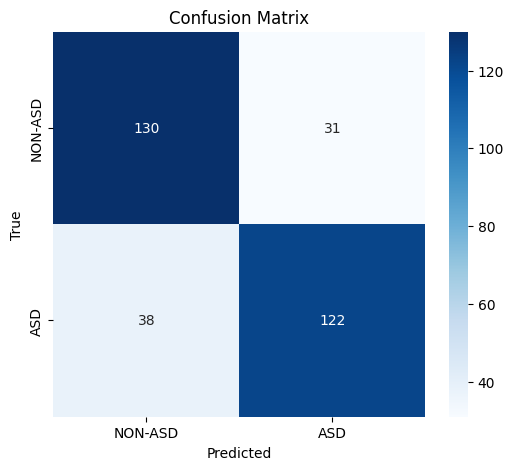

In [55]:
# confusion matrix
cm = confusion_matrix(y_test_arr, pred_labels)
plt.figure(figsize=(6,5))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NON-ASD','ASD'], yticklabels=['NON-ASD','ASD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


---

2. **ROC Curve**: plots **True Positive Rate (TPR)** vs. **False Positive Rate (FPR)**

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

Area under the ROC curve (AUC) measures discrimination power:

* AUC = 1 → Perfect classifier
* AUC = 0.5 → Random guessing




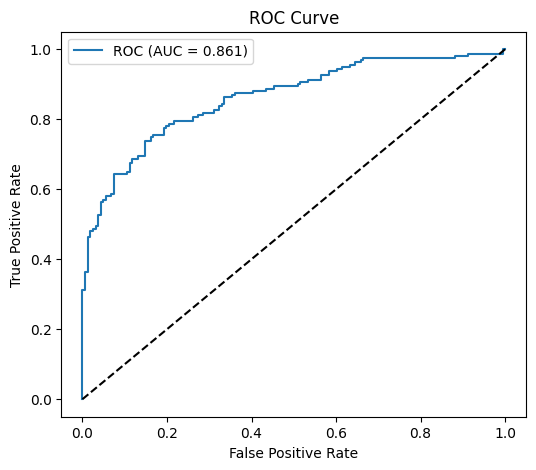

In [56]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test_arr, pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

---

3. **Precision-Recall Curve**:

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}, \quad
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

Average Precision (AP) summarizes the curve as a single number.


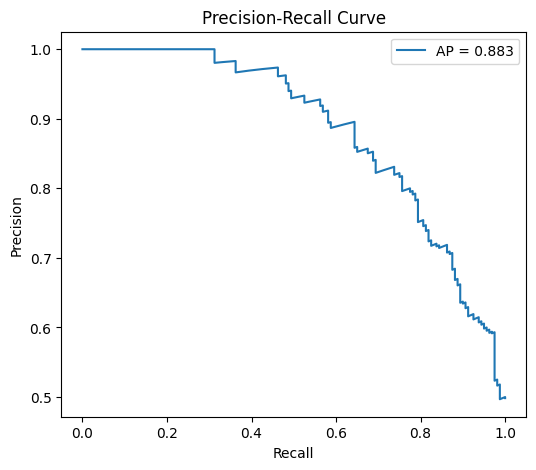

In [57]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_arr, pred_probs)
avg_precision = average_precision_score(y_test_arr, pred_probs)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

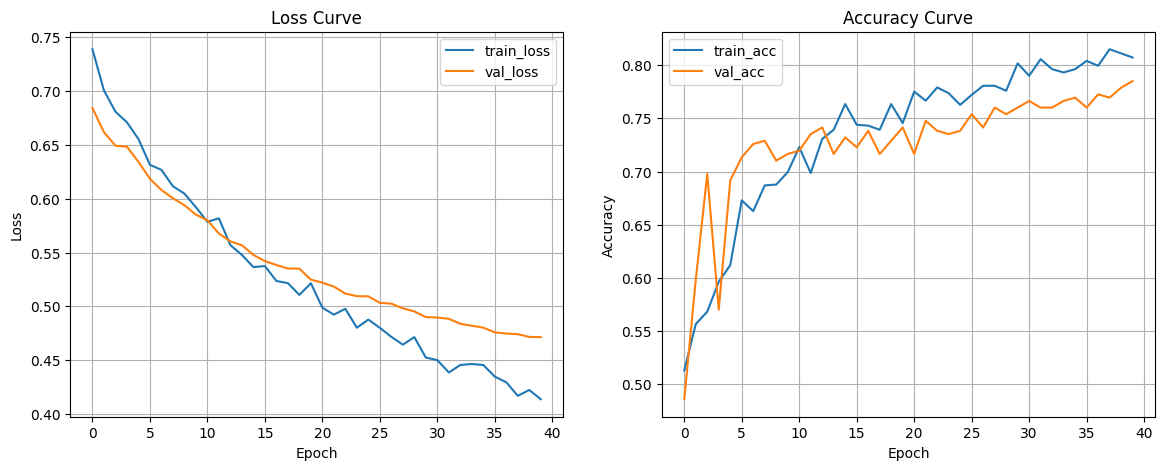

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# -----------------------------
# 1) Plot Training Curves
# -----------------------------
def plot_training_history(history):
    # Loss curve
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)




---

## 9) Inference Function

####  Explanation

We define helper functions:

* **`load_model_and_scaler()`** → loads trained `.keras` model + `StandardScaler`
* **`predict_single()`** → given one MRI image + clinical dict, returns ASD probability & label



Given an MRI image $I$ and clinical vector $\mathbf{c}$, the function:

1. Preprocesses inputs:

   $$
   \mathbf{c}' = \frac{\mathbf{c} - \mu}{\sigma}
   $$

2. Runs forward pass:

   $$
   \hat{y} = f_\theta(I, \mathbf{c}')
   $$

where $f_\theta$ is the trained hybrid model.

3. Outputs:

   * $\hat{y}$ = probability of ASD
   * Predicted class = $1$ if $\hat{y} > 0.5$, else $0$

---


In [61]:
# 13) Inference helper

def load_model_and_scaler(model_path=MODEL_SAVE_PATH, scaler_path=SCALER_SAVE_PATH):
    model = tf.keras.models.load_model(model_path)
    with open(scaler_path, 'rb') as f:
        obj = pickle.load(f)
    return model, obj['scaler'], obj['numeric_cols']

def predict_single(img_path, clinical_dict, model=None, scaler=None, numeric_cols=None, threshold=0.5):
    """
    Predict ASD probability and class for one subject.
    - img_path: str, path to image file
    - clinical_dict: dict of clinical features (can be partial; missing ones filled with 0.0)
    - model, scaler, numeric_cols: loaded from disk if not provided
    - threshold: float, cutoff for ASD vs NON-ASD (default 0.5)
    Returns: (probability, class_label)
    """
    # Load model + scaler if not passed
    if model is None or scaler is None or numeric_cols is None:
        model, scaler, numeric_cols = load_model_and_scaler()

    # --- Process image ---
    img = load_img(img_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # --- Process clinical data ---
    clin_vector = []
    for col in numeric_cols:
        value = clinical_dict.get(col, 0.0)   # fill missing with 0.0
        clin_vector.append(value)
    clin_vector = np.array([clin_vector], dtype=np.float32)
    clin_vector = scaler.transform(clin_vector)

    # --- Predict ---
    prob = model.predict([img, clin_vector], verbose=0)[0][0]
    label = "ASD" if prob >= threshold else "NON-ASD"

    return float(prob), label



---

## 10) Sample Prediction

####  Explanation

We test inference with:

* One MRI image path
* Clinical dict (`AGE_AT_SCAN`, `FIQ`, …)

The function preprocesses both, runs the model, and outputs probability + predicted class.

In [62]:
# example # 1

model, scaler, cols = load_model_and_scaler()

img_path = r"/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD/28675.jpg"

clinical_data = {
    "SEX": 0,  # 1 = male, 0 = female

    # ADI-R (Autism Diagnostic Interview) features
    "ADI_R_SOCIAL_TOTAL_A": 16,
    "ADI_R_VERBAL_TOTAL_BV": 9,
    "ADI_R_RRB_TOTAL_C": 5,
    "ADI_R_ONSET_TOTAL_D": 4,
    "ADI_R_RSRCH_RELIABLE": 1,

    # ADOS (Autism Diagnostic Observation Schedule) features
    "ADOS_MODULE": 4,
    "ADOS_RSRCH_RELIABLE": 1,
    "ADOS_TOTAL": 12,
    "ADOS_COMM": 4,
    "ADOS_SOCIAL": 8,
    "ADOS_STEREO_BEHAV": 3,

    # Age
    "AGE_AT_SCAN": 56.77,

    # Gotham scores
    "ADOS_GOTHAM_SOCAFFECT": 24.63772661,
    "ADOS_GOTHAM_RRB": -4.817178437,
    "ADOS_GOTHAM_TOTAL": 17.57742362,
    "ADOS_GOTHAM_SEVERITY": 23.34030312,

    # MRI Quality Metrics (anatomical features)
    "anat_cnr": 10.20153877,
    "anat_efc": 1.194663818,
    "anat_fber": 16.22345825,
    "anat_fwhm": 3.878000404,
    "anat_qi1": 0.152710978,
    "anat_snr": 12.07245188
}


In [63]:

# now your predict_single will work fine
prob, label = predict_single(img_path, clinical_data, model, scaler, cols)
print(f"ASD probability: {prob:.3f}, Predicted class: {label}")

ASD probability: 0.650, Predicted class: ASD



## Grad-CAM for Hybrid Model (image + clinical)


In [64]:
# ===============================
# Grad-CAM for Hybrid Model (image + clinical)
# ===============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out",
                         clinical_vector=None, num_clin_features=None):
    """
    Grad-CAM heatmap for hybrid (image + clinical) models.

    img_array : (1,H,W,3) preprocessed image
    model : trained hybrid model
    last_conv_layer_name : str, last conv layer in ResNet50 backbone
    clinical_vector : (1,N) scaled clinical features (optional). If None -> dummy zeros
    num_clin_features : int, number of clinical features (needed if dummy)
    """
    # Model inputs
    img_input, clin_input = model.inputs
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Grad-CAM submodel
    grad_model = tf.keras.models.Model(
        inputs=[img_input, clin_input],
        outputs=[last_conv_layer.output, model.output]
    )

    # Clinical vector
    if clinical_vector is None:
        if num_clin_features is None:
            num_clin_features = int(clin_input.shape[-1])
        clinical_vector = np.zeros((1, num_clin_features))

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, clinical_vector])
        loss = predictions[:, 0]  # ASD probability

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


    Overlay + Grid Comparison

In [65]:
def show_gradcam_comparison(img_path, model, img_array, clin_vector_scaled, num_clin_features):
    """
    Show a grid comparing:
    1. Original MRI
    2. Grad-CAM (dummy clinical)
    3. Grad-CAM (real clinical)
    """
    # Heatmaps
    heatmap_dummy = make_gradcam_heatmap(img_array, model,
                                         last_conv_layer_name="conv5_block3_out",
                                         clinical_vector=None,
                                         num_clin_features=num_clin_features)
    heatmap_real = make_gradcam_heatmap(img_array, model,
                                        last_conv_layer_name="conv5_block3_out",
                                        clinical_vector=clin_vector_scaled)

    # Read + resize original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)

    def overlay(img, heatmap, alpha=0.4):
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = np.uint8(255 * jet_heatmap)
        return cv2.addWeighted(img, 1-alpha, jet_heatmap, alpha, 0)

    img_dummy = overlay(img, heatmap_dummy)
    img_real = overlay(img, heatmap_real)

    # Plot grid
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(img_dummy, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM (Dummy Clinical)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM (Real Clinical)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


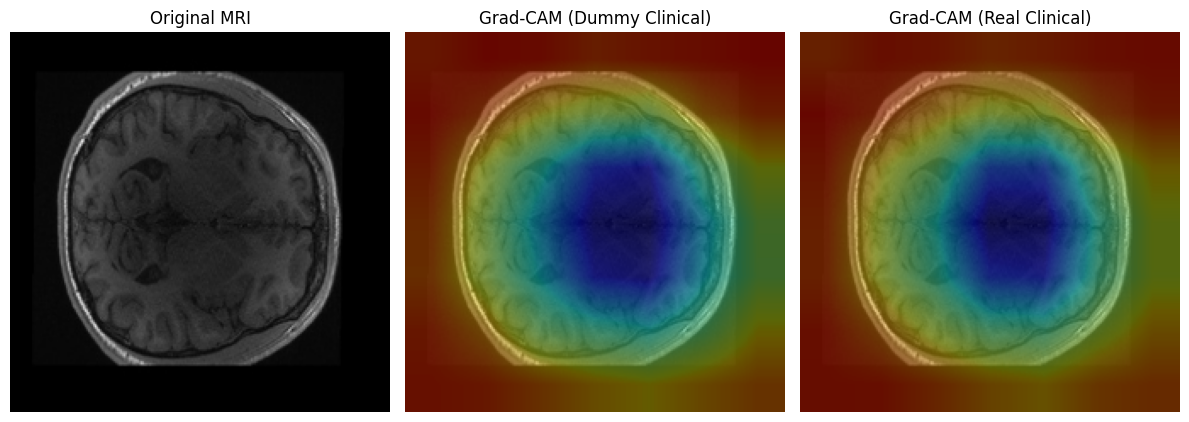

In [68]:
import matplotlib.cm as cm


# Load image
img = load_img(img_path, target_size=IMG_SIZE)
img_arr = img_to_array(img) / 255.0
img_arr = np.expand_dims(img_arr, axis=0)

# Prepare clinical vector (scaled)
clin_vector = []
for col in cols:
    clin_vector.append(clinical_data.get(col, 0.0))
clin_vector = np.array([clin_vector], dtype=np.float32)
clin_vector_scaled = scaler.transform(clin_vector)

# Compare Grad-CAMs
show_gradcam_comparison(img_path, model, img_arr, clin_vector_scaled, num_clin_features=len(cols))


/kaggle/input/abide-jpgs-verion-03/ABIDE MRI JPGs DATASET/ABIDE MRI JPGs DATASET/ASD/28675.jpg
{'SEX': 0, 'ADI_R_SOCIAL_TOTAL_A': 16, 'ADI_R_VERBAL_TOTAL_BV': 9, 'ADI_R_RRB_TOTAL_C': 5, 'ADI_R_ONSET_TOTAL_D': 4, 'ADI_R_RSRCH_RELIABLE': 1, 'ADOS_MODULE': 4, 'ADOS_RSRCH_RELIABLE': 1, 'ADOS_TOTAL': 12, 'ADOS_COMM': 4, 'ADOS_SOCIAL': 8, 'ADOS_STEREO_BEHAV': 3, 'AGE_AT_SCAN': 56.77, 'ADOS_GOTHAM_SOCAFFECT': 24.63772661, 'ADOS_GOTHAM_RRB': -4.817178437, 'ADOS_GOTHAM_TOTAL': 17.57742362, 'ADOS_GOTHAM_SEVERITY': 23.34030312, 'anat_cnr': 10.20153877, 'anat_efc': 1.194663818, 'anat_fber': 16.22345825, 'anat_fwhm': 3.878000404, 'anat_qi1': 0.152710978, 'anat_snr': 12.07245188}
<Functional name=functional, built=True>
StandardScaler()
prob_dummy 0.87064683
label_dummy: ASD
prob_real: 0.6499224
label_real: ASD


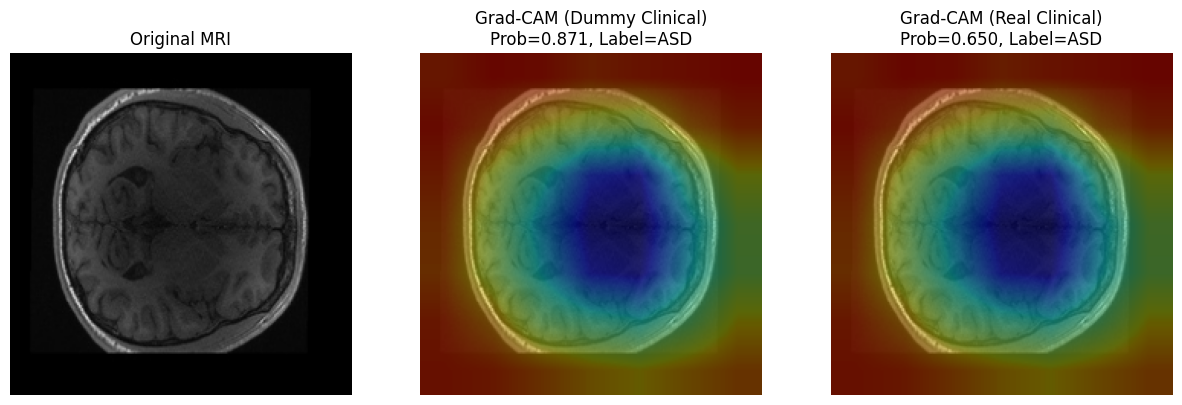

In [69]:
# ===============================
# Grad-CAM Grid with Predictions
# ===============================
def gradcam_with_predictions(img_path, clinical_dict, model, scaler, numeric_cols, last_conv_layer="conv5_block3_out"):
    """
    Show Original MRI, Grad-CAM (Dummy Clinical), Grad-CAM (Real Clinical)
    with predicted probability & class labels.
    """
    # --- Load and preprocess image ---
    img = load_img(img_path, target_size=IMG_SIZE)
    img_arr = img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # --- Clinical processing ---
    clin_vector = []
    for col in numeric_cols:
        clin_vector.append(clinical_dict.get(col, 0.0))
    clin_vector = np.array([clin_vector], dtype=np.float32)
    clin_vector = scaler.transform(clin_vector)

    # --- Predictions ---
    prob_dummy = model.predict([img_arr, np.zeros((1, len(numeric_cols)))], verbose=0)[0][0]
    prob_real  = model.predict([img_arr, clin_vector], verbose=0)[0][0]
    label_dummy = "ASD" if prob_dummy >= 0.5 else "NON-ASD"
    label_real  = "ASD" if prob_real >= 0.5 else "NON-ASD"

    # --- Heatmaps ---
    heatmap_dummy = make_gradcam_heatmap(img_arr, model, last_conv_layer, num_clin_features=len(numeric_cols))
    heatmap_real  = make_gradcam_heatmap(img_arr, model, last_conv_layer, num_clin_features=len(numeric_cols))

    # --- Overlay function ---
    def overlay(img_path, heatmap, alpha=0.4):
        import cv2
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = np.uint8(255 * jet_heatmap)
        return cv2.addWeighted(img, 1-alpha, jet_heatmap, alpha, 0)

    # --- Generate overlays ---
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, IMG_SIZE)
    overlay_dummy = overlay(img_path, heatmap_dummy)
    overlay_real  = overlay(img_path, heatmap_real)

    # --- Plot ---
    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(overlay_dummy, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM (Dummy Clinical)\nProb={prob_dummy:.3f}, Label={label_dummy}")
    plt.axis("off")
    print("prob_dummy", prob_dummy)
    print("label_dummy:", label_dummy)
    
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(overlay_real, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM (Real Clinical)\nProb={prob_real:.3f}, Label={label_real}")
    plt.axis("off")
    print('prob_real:', prob_real)
    print("label_real:", label_real)
    plt.show()


# ===============================
# Example Run
# ===============================
print(img_path)
print(clinical_data)
print(model)
print(scaler)
gradcam_with_predictions(img_path, clinical_data, model, scaler, cols)


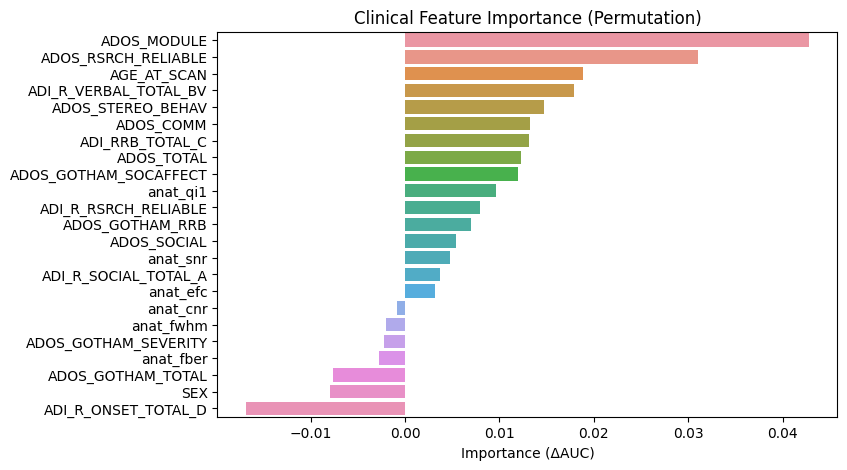

In [70]:
# ===============================
# Clinical Feature Importance (Permutation)
# ===============================
from sklearn.metrics import roc_auc_score
import copy

def permutation_importance(model, X_img, X_clin, y_true, metric=roc_auc_score, n_repeats=5):
    """
    Computes permutation importance for clinical features.
    - model: trained hybrid model
    - X_img: numpy array of images (N,H,W,3)
    - X_clin: numpy array of clinical features (N,F)
    - y_true: true labels (N,)
    """
    baseline_preds = model.predict([X_img, X_clin], verbose=0).ravel()
    baseline_score = metric(y_true, baseline_preds)

    importances = {}
    for j in range(X_clin.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = copy.deepcopy(X_clin)
            np.random.shuffle(X_perm[:, j])  # shuffle column j
            preds = model.predict([X_img, X_perm], verbose=0).ravel()
            scores.append(metric(y_true, preds))
        importances[cols[j]] = baseline_score - np.mean(scores)

    # sort
    importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))
    return importances

# Example usage on validation set
X_img = []
for p in p_test[:100]:  # limit for speed
    img = load_img(p, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    X_img.append(img)
X_img = np.array(X_img)

X_clin = np.array(c_test[:100])
y_true = np.array(y_test[:100])

feat_importances = permutation_importance(model, X_img, X_clin, y_true)
plt.figure(figsize=(8,5))
sns.barplot(x=list(feat_importances.values()), y=list(feat_importances.keys()))
plt.title("Clinical Feature Importance (Permutation)")
plt.xlabel("Importance (ΔAUC)")
plt.show()


---



## 🔹 Diagram

```

                             Input MRI + Clinical Data
                                         │
                         Preprocess (Scaling + Normalization)
                                         │
                                    Hybrid Model
                                         │
                               ┌─────────┴─────────┐
                               │   Probability Ŷ   │
                               └─────────┬─────────┘
                                         │
                              Threshold (0.5 cutoff)
                                         │
                               ┌─────────┴───────────┐
                               │   Predicted Class   │
                               │   ASD / NON-ASD     │
                               └─────────────────────┘

```

---

    < =================================================================================================================== >


---

# Overview — what this notebook does and why

This notebook implements a **hybrid deep-learning pipeline** that combines MRI image information (via a convolutional backbone) with tabular clinical metadata (age, ADOS/ADI/clinical scores, image quality metrics, etc.) to predict ASD vs NON-ASD.

Why hybrid?

* MRI images encode structural/appearance information; deep CNNs (ResNet) can learn hierarchical visual features.
* Clinical variables contain complementary signal (age, diagnostic scores, image quality metrics) which often boost performance when combined with images.
* Concatenating learned image embeddings with clinical embeddings gives the model both spatial and contextual information, improving discrimination.

Key pipeline stages:

1. Data ingestion & sanity checks
2. Clinical feature preprocessing (scaling, imputation)
3. Memory-safe `tf.data` pipeline for image loading + augmentation
4. Hybrid model: pretrained ResNet backbone + clinical dense branch → concatenation → classifier
5. Training with callbacks, class weighting, and validation monitoring
6. Robust evaluation (ROC, PR, confusion matrix, AUC)
7. Inference helper and deployment considerations

---

# Data & assumptions (very important)

* **Images**: JPEG 2D slices (assumed pre-extracted) named by `SUB_ID.jpg` so they can be joined to clinical CSV by `SUB_ID`. If you have multiple slices per subject, you must ensure **no leakage** between train/test — split by *subject* not by file.
* **Clinical CSV**: Must contain `SUB_ID` and numeric clinical features. If `DX_GROUP` appears in both clinical CSV and image-derived labels, decide one canonical source (we drop duplicate from clinical CSV in the code).
* **Labels**: Binary encoded as `0` (NON-ASD) and `1` (ASD).

Pitfalls to watch for:

* Multiple images per subject → ALWAYS split by subject id to avoid leakage.
* Mismatched SUB_ID formats (strings vs ints) → ensure consistent typing before joining.
* Missing clinical values → handle with imputation (mean/median) before scaling.

---

# Clinical preprocessing (detailed logic)

Goal: transform raw clinical columns into a numeric vector suitable for neural network input.

1. **Select numeric columns** (`numeric_cols`) only (drop IDs, labels).
2. **Imputation**: replace missing values with a sensible strategy:

   * Simple: `fillna(0)` if you center features to zero and 0 is acceptable as a placeholder.
   * Better: impute with **training-set median** (robust to outliers) or use a learned imputer (KNN / iterative).
   * Why not drop rows? Medical datasets are often small — prefer imputation.
3. **Standardization** with `StandardScaler`:

   $$
   x' = \frac{x - \mu}{\sigma}
   $$

   * Fit `scaler` on training clinical data only. Save (`pickle`) `scaler` and `numeric_cols` order for inference so new inputs are transformed identically.
4. **Why scale?** Deep networks assume inputs of similar numeric scale — otherwise gradients are dominated by large-magnitude features and training is unstable.

Practical tips:

* Save the scaler and numeric column order to disk (already done) — this is essential for reproducible inference.
* Optionally run PCA if number of clinical features is high and you want dimensionality reduction (but keep interpretability in mind).

---

# Image preprocessing & augmentation (why each op)

**Load & preprocessing steps**:

* Read JPEG bytes → decode → `tf.image.resize` to fixed `IMG_SIZE` (224×224).
* Normalize to `[0,1]` by dividing by 255.0. This keeps magnitudes small and stable.

**Data augmentation (training-only)**:

* `random_flip_left_right` — small, realistic spatial transform that increases invariance.
* `random_brightness` & `random_contrast` — simulates imaging intensity variations across scanners/subjects.
* (Optional) `RandomRotation`, `RandomZoom` — good if slight rotations/scale changes are realistic for your images.

Why augmentation?

* Increases effective dataset size, reduces overfitting, helps the network generalize to scanner/center variability.

Performance notes:

* Do augmentation on the GPU (via `tf.data` map + `AUTOTUNE`) for speed.
* Avoid aggressive transforms that change semantic content (large rotations that break anatomical orientation).

---

# `tf.data` pipeline internals (how it works & why)

We use `tf.data.Dataset` to stream images and clinical vectors without loading them all into RAM.

Flow:

1. `from_tensor_slices(paths)` yields file path strings.
2. `from_tensor_slices(clin_vectors)` yields clinical vectors (floats).
3. `from_tensor_slices(labels)` yields integer labels.
4. `Dataset.zip((paths, clin, labels))` produces triples `(path, clin, label)`.
5. `.shuffle(buffer_size)` (only for training) — buffer size determines randomization; > dataset size = full shuffle.
6. `.map(_map_fn, num_parallel_calls=AUTOTUNE)` applies image decoding, resizing, normalization, and augmentation (for training).
7. `.batch(batch_size)` forms minibatches that match GPU memory.
8. `.prefetch(AUTOTUNE)` keeps the pipeline feeding the GPU efficiently.

Why this design?

* Streaming images from disk avoids OOMs.
* Parallel map + prefetch overlaps data I/O and model computation for faster utilization.
* Clinical vectors are small and kept in memory; images streamed.

Edge cases:

* If images stored on network drive, set a larger prefetch or cache to avoid I/O bottleneck.
* If dataset is small, you can `.cache()` decoded images to RAM or local disk after mapping.

---

# Model architecture: ResNet + Clinical branch (mechanics)

High-level formula:

1. Image branch produces an embedding $\mathbf{f}_{img}$ (after ResNet + pooling + dense).
2. Clinical branch produces $\mathbf{f}_{clin}$ (dense layer).
3. Concatenate: $\mathbf{f}_{combined} = [\mathbf{f}_{img}; \mathbf{f}_{clin}]$
4. Final classifier: dense layers → sigmoid → probability $\hat{y}$.

Why ResNet50?

* Proven feature extractor; pretrained on ImageNet provides good initial filters for edges/textures that translate well to medical images when fine-tuned.

Why `GlobalAveragePooling2D` instead of `Flatten`?

* GAP reduces number of parameters, enforces spatial invariance, reduces overfitting.

Transfer learning strategy:

* **Phase 1**: freeze ResNet base; train top dense layers and clinical branch (low learning rate like 1e-4). This allows classifier to learn how to combine image embedding with clinical data without changing low-level filters.
* **Phase 2 (fine-tune)**: unfreeze last convolutional blocks (e.g., last 10–30 layers) and continue training with a smaller LR (1e-5 or 1e-6). This adapts higher-level image features to your MRI domain.

Layers & shapes:

* Input image: `(B, 224, 224, 3)` → ResNet → `(B, C)` after GAP
* Clinical input: `(B, num_clin_features)` → Dense(64) → `(B, 64)`
* Combined: `(B, C + 64)` → Dense(128) → Dropout → Dense(1) → Sigmoid

---

# Loss & optimization (math + intuition)

**Prediction**:

$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Loss** (binary cross-entropy):

$$
\mathcal{L} = -\big[ y\log(\hat{y}) + (1-y)\log(1-\hat{y})\big]
$$

**Optimization**:

* We use Adam (adaptive gradients) with an initial LR of `1e-4`.
* Reduce LR on plateau halves LR when `val_loss` stops improving for `patience` epochs.
* EarlyStopping halts training if val_loss stops improving (restore best weights).

Gradient update (informal):

* Backprop computes $\nabla_\theta \mathcal{L}$ and Adam updates weights with adaptive momentum — practical, robust for many architectures.

Class weights:

* Compute `class_weight` to compensate sampling imbalances:

  $$
  w_c = \frac{N}{K \cdot N_c}
  $$

  where $N$ is total samples, $N_c$ samples of class $c$, and $K$ number of classes.

Note: class weights affect loss contributions per example and are useful when classes are imbalanced.

---

# Training strategy & hyperparameters (practical)

Recommended baseline:

* `batch_size=32` (if GPU memory allows; reduce if OOM)
* `epochs=20` initially (use early stopping)
* `optimizer=Adam(1e-4)`, then fine-tune with `Adam(1e-5)`
* `dropout=0.3` in dense layers to reduce overfitting
* `steps_per_epoch = ceil(train_samples / batch_size)`

Two-phase training (recommended):

1. Train top classifier and clinical branch for ~10–20 epochs with frozen ResNet.
2. Unfreeze last ResNet blocks and fine-tune with lower LR for ~5–15 more epochs.

Hyperparameter tuning:

* LR: try `1e-4`, `1e-5`, `1e-6` (fine-tuning)
* Dense sizes: 128–512 for image head, 32–128 for clinical head
* Augmentation strength: tune rotation/zoom ranges carefully

Use a small validation set or cross-validation for robust tuning.

---

# Evaluation: interpreting metrics & thresholding

Key metrics:

* **Accuracy** — simple but can be misleading if classes imbalanced.
* **Precision / Recall / F1** — report per-class; medical tasks often prioritize recall (sensitivity) if you want fewer false negatives.
* **ROC AUC** — threshold-independent measure of ranking quality.
* **PR AUC / Average Precision** — more informative if dataset is imbalanced.

Confusion matrix shows counts:

```
[[TN, FP],
 [FN, TP]]
```

For clinical tasks:

* If missing an ASD case is costly → favor higher recall for ASD (lower threshold).
* Choose operating threshold by maximizing a metric (e.g., F1) on validation set or by cost function.

Calibration:

* Neural networks may be poorly calibrated; use **Platt scaling** or **isotonic regression** on validation set to calibrate probabilities (via `sklearn.calibration`).

Confidence intervals:

* Estimate metric uncertainty via **bootstrap**: resample test set many times, compute metric distribution -> 95% CI.

Cross-validation:

* Use **stratified K-fold** on subjects (not image files) to estimate generalization variance.

---

# Interpretability (how to explain predictions)

Must for medical applications:

* **Grad-CAM**: visualize image regions that most influenced prediction (heatmap overlay on MRI).
* **LIME / SHAP**: explain contribution of clinical features to model output (SHAP is usually better for tree models but can be applied to NN via Kernel SHAP).
* **Feature importance**: examine weights in clinical branch and effect on output with partial dependence.

Process:

1. For an example image, compute Grad-CAM on final convolution layer to see spatial saliency.
2. For clinical features, use SHAP or simple ablation to see impact on predicted probability.

---

# Inference & deployment (operational details)

Inference steps:

1. Load `.keras` model and `scaler.pkl` (contains `StandardScaler` and `numeric_cols`).
2. For each subject:

   * Load image and resize/normalize.
   * Construct clinical vector in same `numeric_cols` order; fill missing fields with `0.0` or training-set median.
   * Scale clinical vector via saved scaler.
   * Predict `prob = model.predict([img_batch, clin_batch])`.

Batch inference:

* Make `predict_batch()` that accepts a list of image paths and list of clinical dicts → builds arrays and predicts in batches for speed.

Export & serving:

* Save model as `.keras` (Keras native) or convert to TF SavedModel / TensorFlow Lite / ONNX for serving/mobile.
* For REST serving, wrap preprocessing steps in the service and validate inputs strictly.

Monitoring:

* Log input distributions and prediction drift; re-train if data drift is detected.

---

# Reproducibility & best practices

* Set seeds (`np.random.seed`, `tf.random.set_seed`) for reproducibility. Note that full determinism may require OS-specific flags.
* Save `scaler`, `numeric_cols`, model weights, training config (batch size, LR, augmentation settings), and code version.
* Save training history to disk (loss/metrics) for later plotting.

Environment:

* Record `pip freeze` / `requirements.txt` including TensorFlow and Keras versions — changes in Keras can alter `ModelCheckpoint` behavior (extension `.keras` required).

---

# Troubleshooting & common issues

* **OOM**: reduce `batch_size`, use lower image resolution, or use mixed precision (`tf.keras.mixed_precision`).
* **Slow I/O**: use `.cache()` (if fits) or increase `num_parallel_calls` and `prefetch`. Place images on SSD.
* **Data leakage**: ensure subject-level split when multiple images per subject.
* **Mismatch at inference**: always use the saved scaler & numeric_cols order. Missing order or mismatched columns will produce garbage inputs.
* **Low AUC**: try stronger augmentation, fine-tune ResNet, or try different backbones (EfficientNetB0/B3).
* **Overfitting**: increase augmentation, add dropout, freeze more base layers, or reduce model capacity.

---

# Suggested experiments (priority order)

1. **Two-phase training**: unfreeze last ResNet block and fine-tune with LR 1e-5.
2. **Stronger augmentation**: add `RandomRotation(0.05)` and `RandomZoom(0.1)`.
3. **Try EfficientNetB0** as backbone — often better parameter efficiency.
4. **Ensemble**: train 3 seeds/backbones and average probabilities.
5. **Calibrate** probabilities using validation-set isotonic regression.
6. **Stratified K-fold (subject-wise)** to get robust estimate of generalization.

---

# Ethical, clinical, and limitations notes (mandatory)

* This model is an assistive tool — **not** a clinical diagnosis by itself.
* False positives/negatives have real-world consequences — decide operating threshold carefully and validate on held-out, multi-site data.
* Document dataset provenance, demographic composition, and known scanner biases.
* Keep clinicians in the loop for validation and calibration before deployment.

---

# Quick-reference checklist before training runs

* [ ] Confirm `SUB_ID` alignment and one canonical `DX_GROUP`.
* [ ] Confirm numeric columns in `numeric_cols` are in stable order and saved.
* [ ] Ensure `scaler` fit only on training set.
* [ ] If multiple images per subject, split by subject.
* [ ] Test `predict_single()` on 2–3 examples before large-scale inference.
* [ ] Log training checkpoints, validation AUC, and confusion matrices.

---

If you want, I can:

* Produce the exact **Markdown cells** with LaTeX and diagrams (in Mermaid or ASCII) ready to paste (I can output them as separate blocks), **or**
* Inject these cells into the canvas file you already created (if you want the notebook updated directly).

Which do you prefer? Do you want the Markdown broken into separate blocks that map to each code cell (so you can paste them one-by-one), or a single large Markdown document to paste as an introduction?


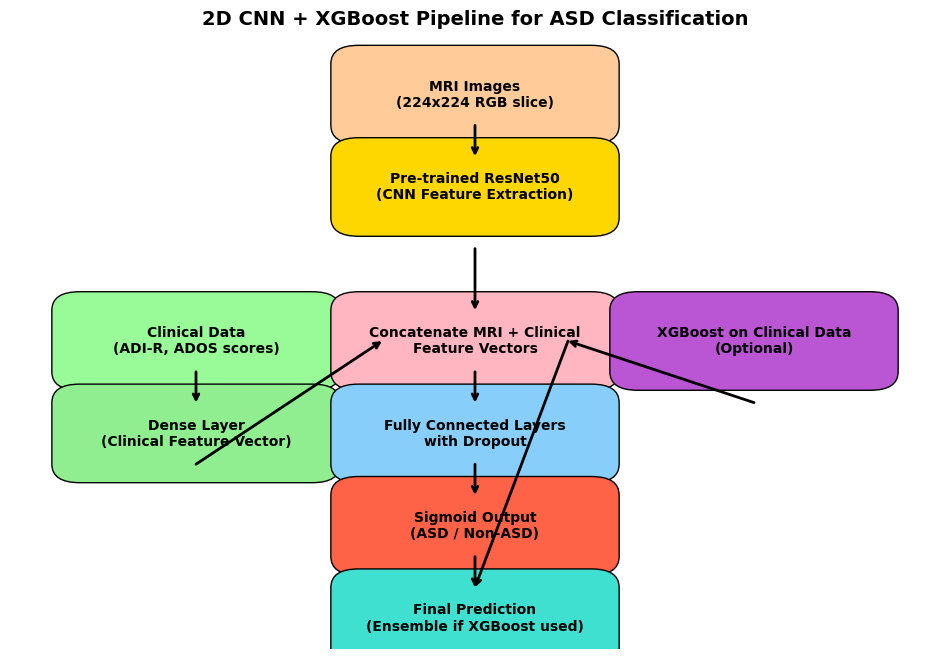

In [73]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

def draw_box(text, xy, width=2.5, height=1, color='#87CEFA'):
    """Draw a box with text at given xy (center) coordinates."""
    x, y = xy
    box = FancyBboxPatch((x-width/2, y-height/2), width, height,
                         boxstyle="round,pad=0.3", edgecolor='black', facecolor=color)
    ax.add_patch(box)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, weight='bold')

def draw_arrow(start, end):
    """Draw an arrow between two points."""
    con = ConnectionPatch(start, end, "data", "data", arrowstyle='->', linewidth=2)
    ax.add_artist(con)

# Step 1: MRI Input
draw_box("MRI Images\n(224x224 RGB slice)", (5, 9), color='#FFCC99')

# Step 2: ResNet50 Feature Extraction
draw_box("Pre-trained ResNet50\n(CNN Feature Extraction)", (5, 7.5), color='#FFD700')
draw_arrow((5, 8.5), (5, 8))  # MRI -> CNN

# Step 3: Clinical Data
draw_box("Clinical Data\n(ADI-R, ADOS scores)", (2, 5), color='#98FB98')

# Step 4: Dense Layer for Clinical Features
draw_box("Dense Layer\n(Clinical Feature Vector)", (2, 3.5), color='#90EE90')
draw_arrow((2, 4.5), (2, 4))  # Clinical -> Dense

# Step 5: Concatenate CNN + Clinical
draw_box("Concatenate MRI + Clinical\nFeature Vectors", (5, 5), color='#FFB6C1')
draw_arrow((5, 6.5), (5, 5.5))  # CNN -> Concatenate
draw_arrow((2, 3), (4, 5))      # Clinical -> Concatenate

# Step 6: Fully Connected Layers
draw_box("Fully Connected Layers\nwith Dropout", (5, 3.5), color='#87CEFA')
draw_arrow((5, 4.5), (5, 4))  # Concatenate -> FC

# Step 7: Sigmoid Output
draw_box("Sigmoid Output\n(ASD / Non-ASD)", (5, 2), color='#FF6347')
draw_arrow((5, 3), (5, 2.5))  # FC -> Output

# Step 8: Optional XGBoost
draw_box("XGBoost on Clinical Data\n(Optional)", (8, 5), color='#BA55D3')
draw_arrow((8, 4), (6, 5))  # XGBoost -> Ensemble

# Step 9: Ensemble Prediction
draw_box("Final Prediction\n(Ensemble if XGBoost used)", (5, 0.5), color='#40E0D0')
draw_arrow((5, 1.5), (5, 1))  # Sigmoid -> Final
draw_arrow((6, 5), (5, 1))    # XGBoost -> Final

plt.title("2D CNN + XGBoost Pipeline for ASD Classification", fontsize=14, weight='bold')
plt.show()
